## Imports and genertic functions

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn_extra.cluster import KMedoids
import copy

In [441]:
np.max(prices_F)

871.0

In [410]:
# cgreen = ()
np.array([146, 185, 131])/255

array([0.57254902, 0.7254902 , 0.51372549])

In [2]:
red = (0.77, 0, 0.05) # (196, 0, 13)
blue = (0.12, 0.24, 1) # (31, 61, 255)
green = (0.31, 1, 0.34) # (79, 255, 87)
navyblue = (0, 0, 0.4) # (0, 0, 102)
black = (0, 0, 0)
white = (1, 1, 1)
cgreen = (0.57254902, 0.7254902 , 0.51372549) # (146, 185, 131)
cblue = (0.70196078, 0.83137255, 1) # (179, 212, 255)

FEATURES_ARE_REDUCED = False
top_domain = 600

def get_hydro_opt(d, lh, ls, lb, max_elec):
    if ls > lh:
        return 0
    elif lb < lh:
        return max_elec
    else:
        return np.minimum(max_elec, np.maximum(0, d))

def import_consts(negative_prices=False):
    all_data = pd.read_csv("./data/2022_data.csv")
    prices_B = np.maximum(all_data["UP"].to_numpy(),0)
    prices_S = np.maximum(all_data["DW"].to_numpy(),0)
    prices_F = np.maximum(all_data["forward_RE"].to_numpy(),0)
    prices_forecast = np.maximum(all_data["forward_FC"].to_numpy(), 0)

    max_elec = 10
    max_wind = 10
    nominal_wind = 10
    min_production = 50

    if FEATURES_ARE_REDUCED:
        features = all_data.loc[:, ["production_FC"]]
    else:
        features = all_data.loc[:, ["Offshore DK2", "Offshore DK1", "Onshore DK2", "Onshore DK1", "production_FC"]]
    features["forward"] = prices_F
    features_red = all_data.loc[:, ["production_FC"]]
    features_red["forward"] = prices_F
    realized = all_data.loc[:, "production_RE"].to_numpy()
    realized *= nominal_wind

    # forecast_production = all_data.loc[:, "production_FC"].to_numpy() * nominal_wind
    forecast_model_df = pd.read_csv("./results/forecast_model.csv")
    forecast_production = forecast_model_df.loc[:,"forecast_production"]

    price_H = 35.199999999999996
    penalty = np.quantile(prices_F, 0.95) # 95% quantile of forward price over all 5 months
    # penalty = 2 * price_H
    # penalty = np.max(prices_B) # Something HIGHER is needed apparently

    return (
        prices_B,
        prices_S,
        prices_F,
        prices_forecast,
        features,
        features_red,
        realized,
        price_H,
        max_elec,
        nominal_wind,
        penalty,
        min_production,
        forecast_production
    )

def get_forward_1(qF, features, t, forecast_model):
    if forecast_model:
        return np.sum([qF.iloc[0, i]*features[i][t] for i in range(len(features))]) + qF.iloc[0, -1]
    else:
        return np.sum([qF.iloc[0, i]*features.iloc[t, i] for i in range(len(features.columns))]) + qF.iloc[0, -1]

def get_forward_24(qF, features, t, forecast_model):
    hour_of_day = (t % 24)
    if forecast_model:
        return np.sum([qF.iloc[hour_of_day, i]*features[i][t] for i in range(len(features))]) + qF.iloc[hour_of_day, -1]
    else:
        return np.sum([qF.iloc[hour_of_day, i]*features.iloc[t, i] for i in range(len(features.columns))]) + qF.iloc[hour_of_day, -1]


def get_hydro_1(qH, features, max_elec, t, forecast_model):
    if forecast_model:
        return np.minimum(max_elec, np.maximum(0, np.sum([qH.iloc[0, i]*features[i][t] for i in range(len(features))]) + qH.iloc[0, -1]))
    else:
        return np.minimum(max_elec, np.maximum(0, np.sum([qH.iloc[0, i]*features.iloc[t, i] for i in range(len(features.columns))]) + qH.iloc[0, -1]))

def get_hydro_24(qH, features, max_elec, t, forecast_model):
    hour_of_day = (t % 24) 
    if forecast_model:
        return np.minimum(max_elec, np.maximum(0, np.sum([qH.iloc[hour_of_day, i]*features[i][t] for i in range(len(features))]) + qH.iloc[hour_of_day, -1]))
    else:
        return np.minimum(max_elec, np.maximum(0, np.sum([qH.iloc[hour_of_day, i]*features.iloc[t, i] for i in range(len(features.columns))]) + qH.iloc[hour_of_day, -1]))

def get_scaled_objs(list_of_results):
    return [np.sum(result['obj'])/(1e6) for result in list_of_results]

def get_remaining_planned_hydro(df, features, max_elec, i):
    hour_of_day = (i % 24) 
    if (hour_of_day == 23):
        return 0
    remaining_hours = 23-hour_of_day
    return np.sum([get_hydro_24(df, features, max_elec, i+j)  for j in range(1, remaining_hours)])

def plot_resulting_objectives(values, names, figsize=(10,4), colors=None):
    xticks = names
    idx = np.asarray([i for i in range(len(xticks))])

    fig, ax = plt.subplots(figsize = figsize)
    ax.set_xticks(idx, )
    ax.set_xticklabels(xticks, rotation=80)
    ax.bar(range(len(values)), values, color=colors)

    for i in range(len(names)-1):
        print(f"{names[i]} revenue is {values[i]*100:.2f} % of {names[-1]}")

    return fig, ax

#---------Simple and Medium

def test_initial_plan(df_f, df_h, idx_start, idx_end, simple=False, forecast_model=False, reduced_features=False):
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    boughts = []
    solds = []
    objs = []
    missing_productions = []
    missing_production = 0
    daily_count = 0

    for i in range(idx_start, idx_end):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and i != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0

        if (simple):
            if forecast_model:
                forward_bid = get_forward_1(df_f, [forecast_production, prices_F], i, forecast_model)
                h_prod = get_hydro_1(df_h, [forecast_production, prices_F], max_elec, i, forecast_model)
            else:
                if reduced_features:
                    forward_bid = get_forward_1(df_f, features_red, i, forecast_model)
                    h_prod = get_hydro_1(df_h, features_red, max_elec, i, forecast_model)
                else:
                    forward_bid = get_forward_1(df_f, features, i, forecast_model)
                    h_prod = get_hydro_1(df_h, features, max_elec, i, forecast_model)
                    
        else:
            if forecast_model:
                forward_bid = get_forward_24(df_f, [forecast_production, prices_F], i, forecast_model)
                h_prod = get_hydro_24(df_h, [forecast_production, prices_F], max_elec, i, forecast_model)
            else:
                if reduced_features:
                    forward_bid = get_forward_24(df_f, features_red, i, forecast_model)
                    h_prod = get_hydro_24(df_h, features_red, max_elec, i, forecast_model)
                else:
                    forward_bid = get_forward_24(df_f, features, i, forecast_model)
                    h_prod = get_hydro_24(df_h, features, max_elec, i, forecast_model)
                    
                
            
        forward_bid = np.minimum(forward_bid, max_elec)
        forward_bid = np.maximum(forward_bid, -max_elec)
        d = realized[i] - forward_bid

        h_prod = np.maximum(h_prod,0)
        h_prod = np.minimum(max_elec, h_prod)

        daily_count += h_prod

        traded = realized[i] - forward_bid - h_prod

        bought = np.maximum(-traded, 0)
        sold = np.maximum(traded, 0)
        obj = (
            forward_bid * prices_F[i]
            + price_H * h_prod
            + sold * prices_S[i]
            - bought * prices_B[i]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        boughts.append(bought)
        solds.append(sold)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "bought": boughts,
        "sold": solds,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results

def test_initial_plan_changing_qs(init_filename, cqs_filename, idx_start, idx_end, simple=False, forecast_model=False, reduced_features=False, weekly=False):
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    boughts = []
    solds = []
    objs = []
    missing_productions = []
    missing_production = 0

    daily_count = 0

    df_retrained = pd.read_csv(init_filename)

    for i in range(idx_start, idx_end):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and i != idx_start:
            # print(f"Check daily count: ", daily_count)
            missing_production = np.maximum(0, min_production - daily_count)
            daily_count = 0

        j = i-idx_start
        if weekly:
            # if (j!= 0) and (j % 24 == 0):
            if (j!= 0) and (j % 168 == 0):
                df_retrained = pd.read_csv(f'{cqs_filename}_we{round(j/168,0):.0f}.csv')
        else:
            # if (j!= 0) and (j % 24 == 0):
            if (j!= 0) and (j % 720 == 0):
                df_retrained = pd.read_csv(f'{cqs_filename}_mo{round(j/720,0):.0f}.csv')


        if forecast_model:
            df_f = df_retrained[[f"qF{i+1}" for i in range(3)]]
            df_h = df_retrained[[f"qH{i+1}" for i in range(3)]]
        else:
            if reduced_features:
                df_f = df_retrained[[f"qF{i+1}" for i in range(int(len(features_red.columns)+1))]]
                df_h = df_retrained[[f"qH{i+1}" for i in range(int(len(features_red.columns)+1))]]
            else:
                df_f = df_retrained[[f"qF{i+1}" for i in range(int(len(features.columns)+1))]]
                df_h = df_retrained[[f"qH{i+1}" for i in range(int(len(features.columns)+1))]]

            
        if (simple):
            if forecast_model:
                forward_bid = get_forward_1(df_f, [forecast_production, prices_F], i, forecast_model)
                h_prod = get_hydro_1(df_h, [forecast_production, prices_F], max_elec, i, forecast_model)
            else:
                if reduced_features:
                    forward_bid = get_forward_1(df_f, features_red, i, forecast_model)
                    h_prod = get_hydro_1(df_h, features_red, max_elec, i, forecast_model)
                else:
                    forward_bid = get_forward_1(df_f, features, i, forecast_model)
                    h_prod = get_hydro_1(df_h, features, max_elec, i, forecast_model)
                    
        else:
            if forecast_model:
                forward_bid = get_forward_24(df_f, [forecast_production, prices_F], i, forecast_model)
                h_prod = get_hydro_24(df_h, [forecast_production, prices_F], max_elec, i, forecast_model)
            else:
                if reduced_features:
                    forward_bid = get_forward_24(df_f, features_red, i, forecast_model)
                    h_prod = get_hydro_24(df_h, features_red, max_elec, i, forecast_model)
                else:
                    forward_bid = get_forward_24(df_f, features, i, forecast_model)
                    h_prod = get_hydro_24(df_h, features, max_elec, i, forecast_model)
                    
        d = realized[i] - forward_bid

        forward_bid = np.minimum(forward_bid, max_elec)
        forward_bid = np.maximum(forward_bid, -max_elec)
        h_prod = np.maximum(h_prod,0)
        h_prod = np.minimum(max_elec, h_prod)
        daily_count += h_prod
        traded = realized[i] - forward_bid - h_prod

        bought = np.maximum(-traded, 0)
        sold = np.maximum(traded, 0)
        obj = (
            forward_bid * prices_F[i]
            + price_H * h_prod
            + sold * prices_S[i]
            - bought * prices_B[i]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        boughts.append(bought)
        solds.append(sold)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "bought": boughts,
        "sold": solds,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results

def test_fixed(forward, hydrogen, idx_start, idx_end):
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    boughts = []
    solds = []
    objs = []
    missing_productions = []
    missing_production = 0
    daily_count = 0

    for i, t in enumerate(range(idx_start, idx_end)):
        hour_of_day = (t % 24) 
        if (hour_of_day == 0) and t != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0

        forward_bid = forward[i]
        d = realized[t] - forward_bid
        h_prod = hydrogen[i]

        traded = realized[t] - forward_bid - h_prod
        daily_count += h_prod

        bought = np.maximum(-traded, 0)
        sold = np.maximum(traded, 0)
        obj = (
            forward_bid * prices_F[t]
            + price_H * h_prod
            + sold * prices_S[t]
            - bought * prices_B[t]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        boughts.append(bought)
        missing_productions.append(missing_production)
        missing_production = 0
        solds.append(sold)
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "bought": boughts,
        "sold": solds,
        "missing_production": missing_productions,
        "obj": objs,
    }

    return results

def test_det(forward, hydrogen, idx_start, idx_end):
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    boughts = []
    solds = []
    objs = []
    missing_productions = []
    missing_production = 0
    daily_count = 0

    for i, t in enumerate(range(idx_start, idx_end)):
        hour_of_day = (t % 24) 
        if (hour_of_day == 0) and t != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0

        if forward[i] >= 0:
            if prices_F[t] > (prices_forecast[t] - 5):
                forward_bid = forward[i]
            else:
                forward_bid = 0
        else:
            if prices_F[t] < (prices_forecast[t] + 5):
                forward_bid = forward[i]
            else:
                forward_bid = 0
        
        
        d = realized[t] - forward_bid
        h_prod = hydrogen[i]

        traded = realized[t] - forward_bid - h_prod
        daily_count += h_prod

        bought = np.maximum(-traded, 0)
        sold = np.maximum(traded, 0)
        obj = (
            forward_bid * prices_F[t]
            + price_H * h_prod
            + sold * prices_S[t]
            - bought * prices_B[t]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        boughts.append(bought)
        missing_productions.append(missing_production)
        missing_production = 0
        solds.append(sold)
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "bought": boughts,
        "sold": solds,
        "missing_production": missing_productions,
        "obj": objs,
    }

    return results


def test_price_domain(df, idx_start, idx_end, simple=False, forecast_model=False, reduced_features=False):
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    boughts = []
    solds = []
    objs = []
    missing_productions = []
    missing_production = 0

    daily_count = 0
    for i in range(idx_start, idx_end):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and i != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0
            
        if prices_F[i] < price_H:
            domain = 1
        elif prices_F[i] < top_domain:
            domain = 2
        else:
            domain = 3

        if forecast_model:
            df_f = df[[f"qF{domain}_{i+1}" for i in range(3)]]
            df_h = df[[f"qH{domain}_{i+1}" for i in range(3)]]
        else:
            if reduced_features:
                df_f = df[[f"qF{domain}_{i+1}" for i in range(int(len(features_red.columns)+1))]]
                df_h = df[[f"qH{domain}_{i+1}" for i in range(int(len(features_red.columns)+1))]]
            else:
                df_f = df[[f"qF{domain}_{i+1}" for i in range(int(len(features.columns)+1))]]
                df_h = df[[f"qH{domain}_{i+1}" for i in range(int(len(features.columns)+1))]]

        if (simple):
            if forecast_model:
                forward_bid = get_forward_1(df_f, [forecast_production, prices_F], i, forecast_model)
                h_prod = get_hydro_1(df_h, [forecast_production, prices_F], max_elec, i, forecast_model)
            else:
                if reduced_features:
                    forward_bid = get_forward_1(df_f, features_red, i, forecast_model)
                    h_prod = get_hydro_1(df_h, features_red, max_elec, i, forecast_model)
                else:
                    forward_bid = get_forward_1(df_f, features, i, forecast_model)
                    h_prod = get_hydro_1(df_h, features, max_elec, i, forecast_model)   
        else:
            if forecast_model:
                forward_bid = get_forward_24(df_f, [forecast_production, prices_F], i, forecast_model)
                h_prod = get_hydro_24(df_h, [forecast_production, prices_F], max_elec, i, forecast_model)
            else:
                if reduced_features:
                    forward_bid = get_forward_24(df_f, features_red, i, forecast_model)
                    h_prod = get_hydro_24(df_h, features_red, max_elec, i, forecast_model)
                else:
                    forward_bid = get_forward_24(df_f, features, i, forecast_model)
                    h_prod = get_hydro_24(df_h, features, max_elec, i, forecast_model)
                    
            
        forward_bid = np.minimum(forward_bid, max_elec)
        forward_bid = np.maximum(forward_bid, -max_elec)
        d = realized[i] - forward_bid

        h_prod = np.maximum(h_prod,0)
        h_prod = np.minimum(max_elec, h_prod)
        daily_count += h_prod
        traded = realized[i] - forward_bid - h_prod

        bought = np.maximum(-traded, 0)
        sold = np.maximum(traded, 0)
        obj = (
            forward_bid * prices_F[i]
            + price_H * h_prod
            + sold * prices_S[i]
            - bought * prices_B[i]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        boughts.append(bought)
        solds.append(sold)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "bought": boughts,
        "sold": solds,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results

def test_price_domain_changing_qs(init_filename, cqs_filename, idx_start, idx_end, simple=False, forecast_model=False, reduced_features=False, weekly=False):
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    boughts = []
    solds = []
    objs = []
    missing_productions = []
    missing_production = 0

    daily_count = 0

    df_retrained = pd.read_csv(init_filename)

    for i in range(idx_start, idx_end):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and i != idx_start:
            # print(f"Check daily count: ", daily_count)
            missing_production = np.maximum(0, min_production - daily_count)
            daily_count = 0

        j = i-idx_start
        if weekly:
            # if (j!= 0) and (j % 24 == 0):
            if (j!= 0) and (j % 168 == 0):
                df_retrained = pd.read_csv(f'{cqs_filename}_we{round(j/168,0):.0f}.csv')
        else:
            # if (j!= 0) and (j % 24 == 0):
            if (j!= 0) and (j % 720 == 0):
                df_retrained = pd.read_csv(f'{cqs_filename}_mo{round(j/720,0):.0f}.csv')

        if prices_F[i] < price_H:
            domain = 1
        elif prices_F[i] < top_domain:
            domain = 2
        else:
            domain = 3

        if forecast_model:
            df_f = df_retrained[[f"qF{domain}_{i+1}" for i in range(3)]]
            df_h = df_retrained[[f"qH{domain}_{i+1}" for i in range(3)]]
        else:
            if reduced_features:
                df_f = df_retrained[[f"qF{domain}_{i+1}" for i in range(int(len(features_red.columns)+1))]]
                df_h = df_retrained[[f"qH{domain}_{i+1}" for i in range(int(len(features_red.columns)+1))]]
            else:
                df_f = df_retrained[[f"qF{domain}_{i+1}" for i in range(int(len(features.columns)+1))]]
                df_h = df_retrained[[f"qH{domain}_{i+1}" for i in range(int(len(features.columns)+1))]]

            
        if (simple):
            if forecast_model:
                forward_bid = get_forward_1(df_f, [forecast_production, prices_F], i, forecast_model)
                h_prod = get_hydro_1(df_h, [forecast_production, prices_F], max_elec, i, forecast_model)
            else:
                if reduced_features:
                    forward_bid = get_forward_1(df_f, features_red, i, forecast_model)
                    h_prod = get_hydro_1(df_h, features_red, max_elec, i, forecast_model)
                else:
                    forward_bid = get_forward_1(df_f, features, i, forecast_model)
                    h_prod = get_hydro_1(df_h, features, max_elec, i, forecast_model)
                    
        else:
            if forecast_model:
                forward_bid = get_forward_24(df_f, [forecast_production, prices_F], i, forecast_model)
                h_prod = get_hydro_24(df_h, [forecast_production, prices_F], max_elec, i, forecast_model)
            else:
                if reduced_features:
                    forward_bid = get_forward_24(df_f, features_red, i, forecast_model)
                    h_prod = get_hydro_24(df_h, features_red, max_elec, i, forecast_model)
                else:
                    forward_bid = get_forward_24(df_f, features, i, forecast_model)
                    h_prod = get_hydro_24(df_h, features, max_elec, i, forecast_model)
                    
        d = realized[i] - forward_bid

        forward_bid = np.minimum(forward_bid, max_elec)
        forward_bid = np.maximum(forward_bid, -max_elec)
        h_prod = np.maximum(h_prod,0)
        h_prod = np.minimum(max_elec, h_prod)
        daily_count += h_prod
        traded = realized[i] - forward_bid - h_prod

        bought = np.maximum(-traded, 0)
        sold = np.maximum(traded, 0)
        obj = (
            forward_bid * prices_F[i]
            + price_H * h_prod
            + sold * prices_S[i]
            - bought * prices_B[i]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        boughts.append(bought)
        solds.append(sold)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "bought": boughts,
        "sold": solds,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results


def apply_upwards_adj(results_to_copy, idx_start, idx_end, printing=False):
    results = copy.deepcopy(results_to_copy) # Does this actually copy or just reference? Is it a problem? Should be fixed
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    boughts = []
    solds = []
    objs = []
    missing_productions = []
    missing_production = 0
    daily_count = 0
    for i, t in enumerate(range(idx_start, idx_end)):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and t != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0

        forward_bid = results['forward_bid'][i]
        h_prod = results['h_prod'][i]

        d = realized[t] - forward_bid
        
        opt_h = get_hydro_opt(d, price_H, prices_S[t], prices_B[t], max_elec)

        hour_of_day = (i % 24) 
        remaining_hours = 23-hour_of_day
        if (hour_of_day == 23):
            remaining_planned = 0
        else:
            remaining_planned = np.sum([results['h_prod'][i+j]  for j in range(1, remaining_hours)])

        if (opt_h > h_prod):
            if printing:
                print(f"i={i}, method 1: We changed from {h_prod} to {opt_h}")
            h_adj = opt_h
        else:
            h_adj = h_prod
        
        daily_count += h_adj
        traded = realized[t] - forward_bid - h_adj
        bought = np.maximum(-traded, 0)
        sold = np.maximum(traded, 0)
        obj = (
            forward_bid * prices_F[t]
            + price_H * h_adj
            + sold * prices_S[t]
            - bought * prices_B[t]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_adj)
        boughts.append(bought)
        solds.append(sold)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "bought": boughts,
        "sold": solds,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results

def apply_up_and_dw_adj(results_to_copy, idx_start, idx_end, printing=False):
    results = copy.deepcopy(results_to_copy) # Does this actually copy or just reference? Is it a problem? Should be fixed
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    boughts = []
    solds = []
    objs = []
    missing_productions = []
    missing_production = 0
    daily_count = 0
    for i, t in enumerate(range(idx_start, idx_end)):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and t != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0

        forward_bid = results['forward_bid'][i]
        h_prod = results['h_prod'][i]

        d = realized[t] - forward_bid
        
        opt_h = get_hydro_opt(d, price_H, prices_S[t], prices_B[t], max_elec)
        
        if (opt_h > h_prod):
            if printing:
                print(f"i={i}, method 1: We changed from {h_prod} to {opt_h}")
            h_adj = opt_h
        # elif (prices_S[t] > penalty):
        #     h_adj = 0
        else:
            remaining_hours = 23-hour_of_day
            if (hour_of_day == 23):
                remaining_planned = 0
            else:
                # remaining_planned = np.sum([results['h_prod'][i+j]  for j in range(1, remaining_hours)])
                remaining_planned = np.sum([results['h_prod'][i+j]  for j in range(remaining_hours+1)])
            surplus = daily_count + remaining_planned - min_production
            wanted = h_prod - opt_h
            if surplus >= wanted:
                h_adj = opt_h
            else:
                h_adj = np.minimum(np.maximum(h_prod - surplus, 0), max_elec)
                if printing:
                    print(f"i={i}, t={t}, hod={hour_of_day}")
                    print(f"planned={remaining_planned}, produced={daily_count}")
                    print(f"surplus={surplus}, wanted={wanted}")
                    print(f"Original prod: {h_prod}, Resulting prod: {h_adj}")
        
        daily_count += h_adj
        traded = realized[t] - forward_bid - h_adj
        bought = np.maximum(-traded, 0)
        sold = np.maximum(traded, 0)
        obj = (
            forward_bid * prices_F[t]
            + price_H * h_adj
            + sold * prices_S[t]
            - bought * prices_B[t]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_adj)
        boughts.append(bought)
        solds.append(sold)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "bought": boughts,
        "sold": solds,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results

def apply_risky_policy(results_to_copy, idx_start, idx_end, printing=False):
    results = copy.deepcopy(results_to_copy) # Does this actually copy or just reference? Is it a problem? Should be fixed
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    boughts = []
    solds = []
    objs = []
    missing_productions = []
    missing_production = 0
    daily_count = 0
    for i, t in enumerate(range(idx_start, idx_end)):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and t != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0

        forward_bid = results['forward_bid'][i]
        h_prod = results['h_prod'][i]

        d = realized[t] - forward_bid
        
        opt_h = get_hydro_opt(d, price_H, prices_S[t], prices_B[t], max_elec)

        hour_of_day = (i % 24) 
        remaining_hours = 23-hour_of_day
        if (hour_of_day == 23):
            remaining_planned = 0
        else:
            remaining_planned = np.sum([results['h_prod'][i+j]  for j in range(1, remaining_hours)])

        if (opt_h > h_prod):
            h_prod = opt_h
        else:
            remaining_hours = 23-hour_of_day
            if (hour_of_day == 23):
                remaining_planned = 0
            else:
                remaining_planned = np.sum([results['h_prod'][i+j]  for j in range(1, remaining_hours)])
            surplus = daily_count + remaining_planned - min_production
            wanted = h_prod - opt_h
            if surplus >= wanted or hour_of_day == 23:
                h_adj = opt_h
            else:
                # Postpone production to later time with low forward price
                forward_prices_remaining = copy.deepcopy(prices_F[t:t+(23-hour_of_day)])
                while wanted > 0:
                    preffered_idx = np.argmin(forward_prices_remaining)
                    price_to_remove = forward_prices_remaining[preffered_idx]
                    if (prices_B[t] < price_to_remove):
                        # If it is cheaper to buy now than we expect it to be later, don't change
                        h_adj = np.minimum(np.maximum(h_prod - surplus, 0), max_elec)
                        break
                    else:
                        free_turn_up = max_elec - results['h_prod'][i+preffered_idx]
                        if (free_turn_up >= wanted):
                            results['h_prod'][i+preffered_idx] += wanted
                            h_adj = opt_h
                            break
                        else:
                            # Turn up as much as much as possible at cheaper later hour
                            results['h_prod'][i+preffered_idx] = max_elec
                            # Reduce the amount we still want accordingly
                            wanted -= free_turn_up
                            # Make the later price unused
                            forward_prices_remaining[preffered_idx] = 9999
                            # Recalculate how much we have in surplus (larger now because we turned up)
                            if (hour_of_day == 23):
                                remaining_planned = 0
                            else:
                                remaining_planned = np.sum([results['h_prod'][i+j]  for j in range(1, remaining_hours)])
                            surplus = daily_count + remaining_planned - min_production


        daily_count += h_prod
        traded = realized[t] - forward_bid - h_prod
        bought = np.maximum(-traded, 0)
        sold = np.maximum(traded, 0)
        obj = (
            forward_bid * prices_F[t]
            + price_H * h_prod
            + sold * prices_S[t]
            - bought * prices_B[t]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        boughts.append(bought)
        solds.append(sold)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "bought": boughts,
        "sold": solds,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results

#-----------------Complex initial

def get_hydro_complex(df, features, max_elec, i):
    hour_of_day = (i % 24) 
    hydrogen = np.sum([
        np.sum([
            df.iloc[row, col] * features[0][i-hour_of_day+row] 
            + df.iloc[row, col+24] * features[1][i-hour_of_day+row] 
            + df.iloc[row, col+24+24] 
            for row in range(24)])
        for col in range(24)])

    return np.minimum(max_elec, np.maximum(0, hydrogen))

def test_complex_initial_plan(df, idx_start, idx_end, min_production=50):
    (
        prices_B,
        prices_S,
        prices_F,
        prices_bal,
        forecast,
        realized,
        price_H,
        max_elec,
        nominal_wind,
        penalty
    ) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    boughts = []
    solds = []
    objs = []
    missing_productions = []
    missing_production = 0

    daily_count = 0
    df_h = pd.DataFrame(df.iloc[:, :-3])
    df_f = pd.DataFrame(df.iloc[:, -3:])

    for i in range(idx_start, idx_end):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and i != idx_start:
            # print(f"Check daily count: ", daily_count)
            missing_production = np.maximum(min_production - daily_count, 0)

            daily_count = 0
        if prices_F[i] > price_H:
            forward_bid = get_forward_24(df_f, [forecast, prices_F], i)
        else:
            forward_bid = 0

        forward_bid = np.maximum(forward_bid,0)
        d = realized[i] - forward_bid

        h_prod = get_hydro_complex(df_h, [forecast, prices_F], max_elec, i)

        h_prod = np.maximum(h_prod,0)
        h_prod = np.minimum(max_elec, h_prod)
        daily_count += h_prod
        traded = realized[i] - forward_bid - h_prod

        bought = np.maximum(-traded, 0)
        sold = np.maximum(traded, 0)
        obj = (
            forward_bid * prices_F[i]
            + price_H * h_prod
            + sold * prices_S[i]
            - bought * prices_B[i]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        boughts.append(bought)
        solds.append(sold)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "bought": boughts,
        "sold": solds,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results

(prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

month = 30*24

In [3]:
idx_start = len(prices_F) - 2*month
idx_end = len(prices_F)
idx_final = len(prices_F)


### Testing the models

#### Deterministic and optimal

In [4]:
#-----------Deterministic
df_det = pd.read_csv("./results/2022/deterministic.csv")

result_det = test_fixed(df_det.loc[:, 'forward bid'], df_det.loc[:, 'hydrogen production'], idx_start, idx_end)
print(f"Deterministic model: {np.sum(result_det['obj'])}")
# Deterministic model: 497157.51979968895

result_det_strict = test_det(df_det.loc[:, 'forward bid'], df_det.loc[:, 'hydrogen production'], idx_start, idx_end)
print(f"Deterministic model +/- : {np.sum(result_det_strict['obj'])}")
print("CHECK LIGE:")
print(np.sum(result_det_strict['obj'][:month]))
#-----------Optimal
df_opt = pd.read_csv("./results/2022/optimal_everything.csv")

result_opt = test_fixed(df_opt.loc[:, 'forward bid'], df_opt.loc[:, 'hydrogen production'], idx_start, idx_end)
print(f"Optimal everything: {np.sum(result_opt['obj'])}")

#-------------EXTRA
df_det_extra = pd.read_csv("./results/2022/deterministic_EXTRA.csv")
result_det_strict_extra = test_det(df_det_extra.loc[:, 'forward bid'], df_det_extra.loc[:, 'hydrogen production'], idx_start+month, idx_end)
print(f"EXTRA: Deterministic model +/- : {np.sum(result_det_strict_extra['obj'])}")
df_opt_extra = pd.read_csv("./results/2022/optimal_everything_EXTRA.csv")
result_opt_extra = test_fixed(df_opt_extra.loc[:, 'forward bid'], df_opt_extra.loc[:, 'hydrogen production'], idx_start+month, idx_end)
print(f"EXTRA: Optimal everything: {np.sum(result_opt_extra['obj'])}")


Deterministic model: 725724.0996302967
Deterministic model +/- : 629827.2524600937
CHECK LIGE:
-48801.19802713819
Optimal everything: 819956.112632073
EXTRA: Deterministic model +/- : 678628.4504872318
EXTRA: Optimal everything: 801927.0501302731


#### Simple models

##### Simple

In [315]:

#--------------------------SIMPLE-----------------

def test_simple(model_name, forecast_model=False, reduced_features=False):
    results = []
    print("\nTesting model ", model_name)
    for i in range(3):
        df = pd.read_csv(f"./results/2022/comparing_architecture/{model_name}_mo{i+1}.csv")
        df_f = df[[f"qF{i+1}" for i in range(int(len(df.columns)/2))]]
        df_h = df[[f"qH{i+1}" for i in range(int(len(df.columns)/2))]]
        tester_results = test_initial_plan(df_f, df_h, idx_start, idx_end, True, forecast_model, reduced_features)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results

# # SIMPLE For all features - best was 1 months training: 1183139
# results_s_all = test_simple("SIMPLE")

# SIMPLE Only forecast and price features - best was 1 months training: 1183139
results_s_fp = test_simple("SIMPLE_fp", False, True)

# SIMPLE Forecast model - best was 1 months training: 1183139
results_s_model = test_simple("SIMPLE_forecast_model", True)



Testing model  SIMPLE_fp
1 months training: 408251.8880913304
2 months training: 420825.59296617634
3 months training: 425336.6193145495

Testing model  SIMPLE_forecast_model
1 months training: 330864.75005933177
2 months training: 343607.51526726986
3 months training: 332562.89194946346


##### Simple PD

In [316]:

#--------------------------simple_PRICEDOMAIN-----------------

def test_simple_pd(model_name, forecast_model=False, reduced_features=False):
    results = []
    print("\nTesting model ", model_name)
    for i in range(3):
        df = pd.read_csv(f"./results/2022/pricedomains/{model_name}_mo{i+1}.csv")
        tester_results = test_price_domain(df, idx_start, idx_end, True, forecast_model, reduced_features)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results

# # simple_PRICEDOMAIN For all features - best was 
# results_s_all_PD = test_simple_pd("simple_PRICEDOMAIN")

# simple_PRICEDOMAIN Only forecast and price features - best was 1 months training: 1013904
results_s_fp_PD = test_simple_pd("simple_fp_PRICEDOMAIN", False, True)

# simple_PRICEDOMAIN Forecast model - best was 1 months training: 1013904
results_s_model_PD = test_simple_pd("simple_forecast_model_PRICEDOMAIN", True)




Testing model  simple_fp_PRICEDOMAIN
1 months training: 408756.20724954084
2 months training: 410256.69846304576
3 months training: 407287.4881428041

Testing model  simple_forecast_model_PRICEDOMAIN
1 months training: 410683.1603910504
2 months training: 414327.0872995304
3 months training: 402425.26201854437


##### Simple pd Oracle

In [317]:

#--------------------------simple_pricedomain_ORACLE-----------------

def test_simple_pd_oracle(model_name, forecast_model=False):
    results = []
    print("\nTesting model ", model_name)
    df = pd.read_csv(f"./results/2022/pricedomains/{model_name}.csv")
    tester_results = test_price_domain(df, idx_start, idx_end, True, forecast_model)
    results.append(tester_results)
    print(f"Result: {np.sum(tester_results['obj'])}")
    return results

# simple_pricedomain_ORACLE For all features - result was
# results_s_all_pd_ORACLE = test_simple_pd_oracle("simple_pricedomain_ORACLE")

# # simple_pricedomain_ORACLE Only forecast and price features - result was 
# # TO RUN THIS BLOCK YOU NEED TO CHANGE "FEATURES_ARE_REDUCED" TO True 
# results_s_fp_pd_ORACLE = test_simple_pd_oracle("simple_fp_pricedomain_ORACLE")

# # simple_pricedomain_ORACLE Forecast model - result was 1185500
# results_s_model_pd_ORACLE = test_simple_pd_oracle("simple_forecast_model_pricedomain_ORACLE", True)


##### Simple pd Retraining

In [318]:
#--------------------------simple_pricedomain_RETRAINING-----------------

def test_simple_pd_retraining(init_filename, model_name, forecast_model=False, reduced_features=False):
    results = []
    print("\nTesting model ", model_name)
    for i in range(3):
        cqs_filename = (f"./results/2022/changing_qs_simple/{i+1}_month_training/{model_name}")
        tester_results = test_price_domain_changing_qs(init_filename, cqs_filename, idx_start, idx_end, True, forecast_model, reduced_features)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results

# # simple_pricedomain_RETRAINING For all features - best was 
# s_all_pd_init = f"./results/2022/pricedomains/simple_PRICEDOMAIN_mo1.csv"
# results_s_all_PD_retrained = test_simple_pd_retraining(s_all_pd_init, "simple_pricedomain_RETRAINING")

# simple_pricedomain_RETRAINING Only forecast and price features - best was
s_fp_pd_init = f"./results/2022/pricedomains/simple_fp_PRICEDOMAIN_mo1.csv"
results_s_fp_PD_retrained = test_simple_pd_retraining(s_fp_pd_init, "simple_fp_pricedomain_RETRAINING", False, True)

# simple_pricedomain_RETRAINING For all features - best was 
s_model_pd_init = f"./results/2022/pricedomains/simple_forecast_model_PRICEDOMAIN_mo1.csv"
results_s_model_PD_retrained = test_simple_pd_retraining(s_model_pd_init, "simple_forecasted_model_pricedomain_RETRAINING", True)



Testing model  simple_fp_pricedomain_RETRAINING
1 months training: 408756.20724954084
2 months training: 401248.61941445514
3 months training: 401182.55895827955

Testing model  simple_forecasted_model_pricedomain_RETRAINING
1 months training: 410683.1603910504
2 months training: 406457.40761506825
3 months training: 401460.12595049746


#### Medium models

##### Medium

In [319]:

#--------------------------MEDIUM-----------------

def test_medium(model_name, forecast_model=False, reduced_features=False):
    results = []
    print("\nTesting model ", model_name)
    for i in range(3):
        df = pd.read_csv(f"./results/2022/comparing_architecture/{model_name}_mo{i+1}.csv")
        df_f = df[[f"qF{i+1}" for i in range(int(len(df.columns)/2))]]
        df_h = df[[f"qH{i+1}" for i in range(int(len(df.columns)/2))]]
        tester_results = test_initial_plan(df_f, df_h, idx_start, idx_end, False, forecast_model, reduced_features)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results

# # MEDIUM For all features - best was 2 months training: 1438622
# results_m_all = test_medium("MEDIUM")

# MEDIUM Only forecast and price features - best was 1 months training: 
results_m_fp = test_medium("MEDIUM_fp", False, True)

# MEDIUM Forecast model - best was 1 months training: 1491696
results_m_model = test_medium("MEDIUM_forecast_model", True)



Testing model  MEDIUM_fp
1 months training: 562638.8215305872
2 months training: 608706.0251155213
3 months training: 616255.1525278414

Testing model  MEDIUM_forecast_model
1 months training: 556881.3005808952
2 months training: 610070.385801447
3 months training: 615769.1215054411


##### Medium PD

In [23]:

#--------------------------medium_PRICEDOMAIN-----------------

def test_medium_pd(model_name, forecast_model=False, reduced_features=False):
    results = []
    print("\nTesting model ", model_name)
    for i in range(3):
        df = pd.read_csv(f"./results/2022/pricedomains/{model_name}_mo{i+1}.csv")
        tester_results = test_price_domain(df, idx_start, idx_end, False, forecast_model, reduced_features)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results

# # medium_PRICEDOMAIN For all features - best was 
# results_m_all_PD = test_medium_pd("medium_PRICEDOMAIN")

# # medium_PRICEDOMAIN Only forecast and price features - best was 
# results_m_fp_PD = test_medium_pd("medium_fp_PRICEDOMAIN", False, True)

# # medium_PRICEDOMAIN Forecast model - best was 
# results_m_model_PD = test_medium_pd("medium_forecast_model_PRICEDOMAIN", True)


def test_medium_pd_EXTRA(model_name, forecast_model=False, reduced_features=False):
    results = []
    print("\nTesting model ", model_name)
    for i in range(4):
        df = pd.read_csv(f"./results/2022/pricedomains/{model_name}_EXTRA_mo{i+1}.csv")
        tester_results = test_price_domain(df, idx_start+month, idx_end, False, forecast_model, reduced_features)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results

# medium_PRICEDOMAIN FP - best was 
results_m_all_PD = test_medium_pd_EXTRA("medium_PRICEDOMAIN")


# medium_PRICEDOMAIN FP - best was 
results_m_fpPD = test_medium_pd_EXTRA("medium_fp_PRICEDOMAIN", False, True)

# medium_PRICEDOMAIN Forecast model - best was 
results_m_model_PD = test_medium_pd_EXTRA("medium_forecast_model_PRICEDOMAIN", True)


Testing model  medium_PRICEDOMAIN
1 months training: 537501.5663227737
2 months training: 652245.374690675
3 months training: 690251.2371901845
4 months training: 689195.4416494933

Testing model  medium_fp_PRICEDOMAIN
1 months training: 640890.723383016
2 months training: 680586.8699155033
3 months training: 694362.4369476154
4 months training: 700057.0053329731

Testing model  medium_forecast_model_PRICEDOMAIN
1 months training: 651258.9954311444
2 months training: 679389.716987875
3 months training: 696756.0440897006
4 months training: 704149.7310074577


In [21]:
np.mean(prices_F[4*month:])

360.91614583333336

##### Medium retraining

In [321]:

def test_medium_retrained(init_filename, model_name, forecast_model=False, reduced_features=False, weekly=True):
    results = []
    print("\nTesting monthly model ", model_name)
    for i in range(3):
        cqs_filename = (f"./results/2022/changing_qs_medium/{i+1}_month_training/{model_name}")
        tester_results = test_initial_plan_changing_qs(init_filename, cqs_filename, idx_start, idx_end, False, forecast_model, reduced_features, weekly)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results

m_fp_init = f"./results/2022/comparing_architecture/medium_fp_mo3.csv"
results_m_fp_retrained = test_medium_retrained(m_fp_init, "medium_fp_RETRAINING", False, True)

m_model_init = f"./results/2022/comparing_architecture/MEDIUM_forecast_model_mo3.csv"
results_m_model_retrained = test_medium_retrained(m_model_init, "medium_forecast_model_RETRAINING", True)



Testing monthly model  medium_fp_RETRAINING
1 months training: 563805.7393546265
2 months training: 608950.5981202652
3 months training: 616255.1525278414

Testing monthly model  medium_forecast_model_RETRAINING
1 months training: 557927.5448578551
2 months training: 610316.1209424646
3 months training: 615769.1215054411


##### Medium pd Oracle

In [322]:

#--------------------------medium_pricedomain_ORACLE-----------------

def test_medium_pd_oracle(model_name, forecast_model=False, reduced_features=False):
    results = []
    print("\nTesting model ", model_name)
    df = pd.read_csv(f"./results/2022/pricedomains/{model_name}.csv")
    tester_results = test_price_domain(df, idx_start, idx_end, False, forecast_model, reduced_features)
    results.append(tester_results)
    print(f"Result: {np.sum(tester_results['obj'])}")
    return results

# # medium_PRICEDOMAIN For all features - result was 
# results_m_all_pd_ORACLE = test_medium_pd_oracle("medium_pricedomain_ORACLE")

# medium_PRICEDOMAIN Only forecast and price features - result was 
# TO RUN THIS BLOCK YOU NEED TO CHANGE "FEATURES_ARE_REDUCED" TO True 
results_m_fp_pd_ORACLE = test_medium_pd_oracle("medium_fp_pricedomain_ORACLE", False, True)

# medium_PRICEDOMAIN Forecast model - result was 
results_m_model_pd_ORACLE = test_medium_pd_oracle("medium_forecast_model_pricedomain_ORACLE", True)



Testing model  medium_fp_pricedomain_ORACLE
Result: 690002.9381912036

Testing model  medium_forecast_model_pricedomain_ORACLE
Result: 690203.2629395848


##### Medium pd Retraining

In [323]:
#--------------------------medium_pricedomain_RETRAINING-----------------

def test_medium_pd_retraining(init_filename, model_name, forecast_model=False, reduced_features=False):
    results = []
    print("\nTesting monthly model ", model_name)
    for i in range(3):
        cqs_filename = (f"./results/2022/changing_qs_medium/{i+1}_month_training/{model_name}")
        tester_results = test_price_domain_changing_qs(init_filename, cqs_filename, idx_start, idx_end, False, forecast_model, reduced_features)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results


def test_medium_pd_retraining_weekly(init_filename, model_name, forecast_model=False, reduced_features=False):
    results = []
    print("\nTesting weekly model ", model_name)
    for i in range(3):
        cqs_filename = (f"./results/2022/changing_qs_medium/{i+1}_month_training/{model_name}")
        tester_results = test_price_domain_changing_qs(init_filename, cqs_filename, idx_start, idx_end, False, forecast_model, reduced_features, True)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results
# # simple_pricedomain_RETRAINING For all features - best was 
# m_all_pd_init = f"./results/2022/pricedomains/medium_PRICEDOMAIN_mo1.csv"
# results_m_all_PD_retrained = test_medium_pd_retraining(m_all_pd_init, "medium_pricedomain_RETRAINING")

# # simple_pricedomain_RETRAINING Only forecast and price features - best was 
# m_fp_pd_init = f"./results/2022/pricedomains/medium_fp_PRICEDOMAIN_mo3.csv"
# results_m_fp_PD_retrained = test_medium_pd_retraining(m_fp_pd_init, "medium_fp_pricedomain_RETRAINING", False, True)

# # # simple_pricedomain_RETRAINING Forecast model - best was 
# m_model_pd_init = f"./results/2022/pricedomains/medium_forecast_model_PRICEDOMAIN_mo3.csv"
# results_m_model_PD_retrained = test_medium_pd_retraining(m_model_pd_init, "medium_forecast_model_pricedomain_RETRAINING", True)

# simple_pricedomain_RETRAINING Only forecast and price features - best was 
m_fp_pd_init = f"./results/2022/pricedomains/medium_fp_PRICEDOMAIN_mo3.csv"
results_m_fp_PD_retrained = test_medium_pd_retraining_weekly(m_fp_pd_init, "medium_fp_pricedomain_RETRAINING", False, True)

# # simple_pricedomain_RETRAINING Forecast model - best was 
m_model_pd_init = f"./results/2022/pricedomains/medium_forecast_model_PRICEDOMAIN_mo3.csv"
results_m_model_PD_retrained = test_medium_pd_retraining_weekly(m_model_pd_init, "medium_forecast_model_pricedomain_RETRAINING", True)


# # HIGH penalty 
# m_model_pd_init = f"./results/2022/pricedomains/medium_forecast_model_PRICEDOMAIN_mo3.csv"
# results_m_model_PD_retrained_highpen = test_medium_pd_retraining_weekly(m_model_pd_init, "medium_forecast_model_pricedomain_RETRAINING", True)



Testing weekly model  medium_fp_pricedomain_RETRAINING
1 months training: 587614.6599060581
2 months training: 618493.1649974684
3 months training: 626757.2896142568

Testing weekly model  medium_forecast_model_pricedomain_RETRAINING
1 months training: 582511.2300266919
2 months training: 620150.8750319772
3 months training: 627335.5678225515


In [ ]:
def printstuff(r1, r2, trange, maxcount=10):
    counter = 0
    for i in trange:
        if counter > maxcount:
            break
        if round(r2['obj'][i], 0) < round(r1['obj'][i], 0):
            counter += 1
            t = i+idx_start
            print(f"\ni={i}, fp={prices_F[t]}, sp={prices_S[t]}, bp={prices_B[t]}, realized={realized[t]}, opt_h={get_hydro_opt(realized[t]-r1['forward_bid'][i], price_H, prices_S[t], prices_B[t], max_elec)}")
            print(f"ori: {r1['obj'][i]:.2f}, fb={r1['forward_bid'][i]:.2f}, hprod={r1['h_prod'][i]:.2f}, sold={r1['sold'][i]:.2f}, bought={r1['bought'][i]:.2f}, missing={r1['missing_production'][i]:.2f}")
            print(f"should-be-better: {r2['obj'][i]:.2f}, fb={r2['forward_bid'][i]:.2f}, hprod={r2['h_prod'][i]:.2f}, sold={r2['sold'][i]:.2f}, bought={r2['bought'][i]:.2f}, missing={r2['missing_production'][i]:.2f}")


printstuff(results_m_model_PD_retrained[1], result_opt, range(idx_end-idx_start))


#### Adjustment

In [246]:
def adjust(res):
    res_up = apply_upwards_adj(res, idx_start, idx_end)
    res_up_dw = apply_up_and_dw_adj(res, idx_start, idx_end)
    res_pp = apply_risky_policy(res, idx_start, idx_end)
    return res_up, res_up_dw, res_pp

##### Deterministic

In [157]:
det_up = apply_upwards_adj(result_det, idx_start, idx_end)
det_up_dw = apply_up_and_dw_adj(result_det, idx_start, idx_end)
det_pp = apply_risky_policy(result_det, idx_start, idx_end)
print("Original: ", np.sum(result_det['obj']))
print("Upwards adj: ", np.sum(det_up['obj']))
print("Up + dw adj: ", np.sum(det_up_dw['obj']))
print("Postponing adj: ", np.sum(det_pp['obj']))

Original:  497157.51979968895
Upwards adj:  498417.51979968895
Up + dw adj:  575493.3683104299
Postponing adj:  231968.3280949185


##### Simple

In [156]:
other_up = apply_upwards_adj(results_s_model_PD[2], idx_start, idx_end)
other_up_dw = apply_up_and_dw_adj(results_s_model_PD[2], idx_start, idx_end)
other_pp = apply_risky_policy(results_s_model_PD[2], idx_start, idx_end)
print("Original: ", np.sum(results_s_model_PD[2]['obj']))
print("Upwards adj: ", np.sum(other_up['obj']))
print("Up + dw adj: ", np.sum(other_up_dw['obj']))
print("Postponing adj: ", np.sum(other_pp['obj']))

Original:  402425.26201854437
Upwards adj:  403339.8939402129
Up + dw adj:  488049.8555924696
Postponing adj:  200569.93087797402


##### Medium

In [242]:
best_up = apply_upwards_adj(results_m_model_PD_retrained[2], idx_start, idx_end)
best_up_dw = apply_up_and_dw_adj(results_m_model_PD_retrained[2], idx_start, idx_end)
best_pp = apply_risky_policy(results_m_model_PD_retrained[2], idx_start, idx_end)
print("Original: ", np.sum(results_m_model_PD_retrained[2]['obj']))
print("Upwards adj: ", np.sum(best_up['obj']))
print("Up + dw adj: ", np.sum(best_up_dw['obj']))
print("Postponing adj: ", np.sum(best_pp['obj']))

Original:  668119.0478225516
Upwards adj:  669210.4730539926
Up + dw adj:  637669.0787641337
Postponing adj:  512440.655728754


In [227]:
print("Before adj: ", np.sum(best['missing_production']))
print("After adj: ", np.sum(best_up_dw['missing_production']))

Before adj:  80.0
After adj:  0.0


In [81]:
def printstuff(r1, r2, trange, maxcount=10):
    counter = 0
    for i in trange:
        if counter > maxcount:
            break
        if round(r2['obj'][i], 0) < round(r1['obj'][i], 0):
            counter += 1
            t = i+idx_start
            print(f"\ni={i}, fp={prices_F[t]}, sp={prices_S[t]}, bp={prices_B[t]}, realized={realized[t]}, opt_h={get_hydro_opt(realized[t]-r1['forward_bid'][i], price_H, prices_S[t], prices_B[t], max_elec)}")
            print(f"ori: {r1['obj'][i]:.2f}, fb={r1['forward_bid'][i]:.2f}, hprod={r1['h_prod'][i]:.2f}, sold={r1['sold'][i]:.2f}, bought={r1['bought'][i]:.2f}, missing={r1['missing_production'][i]:.2f}")
            print(f"should-be-better: {r2['obj'][i]:.2f}, fb={r2['forward_bid'][i]:.2f}, hprod={r2['h_prod'][i]:.2f}, sold={r2['sold'][i]:.2f}, bought={r2['bought'][i]:.2f}, missing={r2['missing_production'][i]:.2f}")

#### Plots

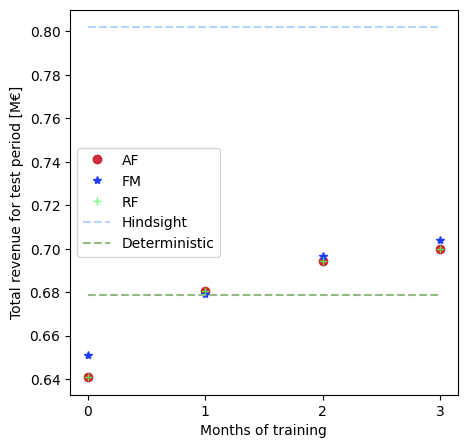

In [27]:
factor_dw = 1e6
all_objs = [np.sum(res['obj'])/factor_dw for res in results_m_all_PD]
fp_objs = [np.sum(res['obj'])/factor_dw for res in results_m_fpPD]
model_objs = [np.sum(res['obj'])/factor_dw for res in results_m_model_PD]

optimals = [np.sum(result_opt_extra['obj'])/factor_dw for _ in range(4)]
deterministics = [np.sum(result_det_strict_extra['obj'])/factor_dw for _ in range(4)]


xs = range(4)
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(xs, fp_objs, 'o', color=red, alpha=0.8, label="AF")
ax.plot(xs, model_objs, '*', color=blue, label="FM")
ax.plot(xs, fp_objs, '+', color=green, alpha=0.8, label="RF")
ax.plot(xs, optimals, '--', color=cblue, label="Hindsight")
ax.plot(xs, deterministics, '--', color=cgreen, label="Deterministic")
ax.legend()
ax.set_xlabel("Months of training")
ax.set_ylabel("Total revenue for test period [M€]")
# ax.set_ylim(0, 1)
ax.set_xticks(xs)
fig.savefig("./pdfs/2022_results.pdf")

C:\Users\emilh\AppData\Local\Temp\ipykernel_6340\2107365894.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=45)
C:\Users\emilh\AppData\Local\Temp\ipykernel_6340\2107365894.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


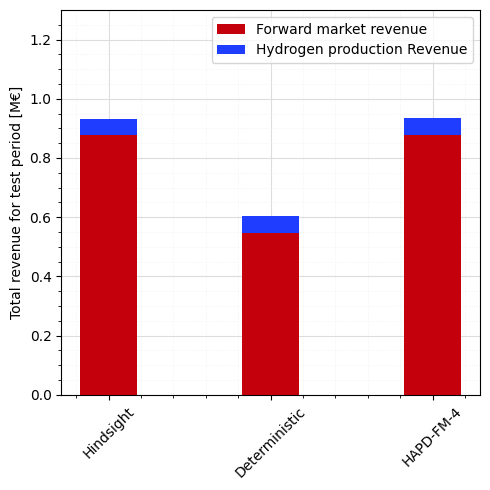

In [35]:
fig, ax = plt.subplots(figsize=(5,5))
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.minorticks_on()
ax.set_axisbelow(True)
values = np.array([
    np.sum([result_opt_extra['forward_bid'][i]*prices_F[t] for i,t in enumerate(range(idx_end-month, idx_end)) if result_opt_extra['forward_bid'][i] > 0]),
    np.sum([result_det_strict_extra['forward_bid'][i]*prices_F[t] for i,t in enumerate(range(idx_end-month, idx_end)) if result_det_strict_extra['forward_bid'][i] > 0]),
    np.sum([results_m_model_PD[3]['forward_bid'][i]*prices_F[t] for i,t in enumerate(range(idx_end-month, idx_end)) if results_m_model_PD[3]['forward_bid'][i] > 0]),
])

hydrogens = np.array([
    np.sum([result_opt_extra['h_prod'][i]*price_H for i,t in enumerate(range(idx_end-month, idx_end))]),
    np.sum([result_det_strict_extra['h_prod'][i]*price_H for i,t in enumerate(range(idx_end-month, idx_end))]),
    np.sum([results_m_model_PD[3]['h_prod'][i]*price_H for i,t in enumerate(range(idx_end-month, idx_end))]),
])
values *= 1/1e6
hydrogens *= 1/1e6
xlabels = ["Hindsight", "Deterministic", "HAPD-FM-4"]
xs = range(len(values))
ax.bar(xs, values, width, color=red, label="Forward market revenue")
ax.bar(xs, hydrogens, width, bottom=values, color=blue, label="Hydrogen production Revenue")
# if plot_penalties:
#     ax.bar(xs, penalties, width, bottom=values, color=blue, label="Penalty Loss")
# if plot_adjustments:
#     ax.bar(xs, adjustments, width, bottom=values, color=blue, label="Adjustment Revenue")
ax.set_xticklabels(xlabels, rotation=45)
ax.set_xticks(xs)
ax.set_ylabel("Total revenue for test period [M€]")
ax.set_ylim(0, 1.3)
fig.show()
fig.tight_layout()
ax.legend()
fig.savefig("./pdfs/rev_dist_2022.pdf")

In [41]:
np.sum(result_opt_extra['obj'])/1e6 / model_objs[3]

1.1388587040755112

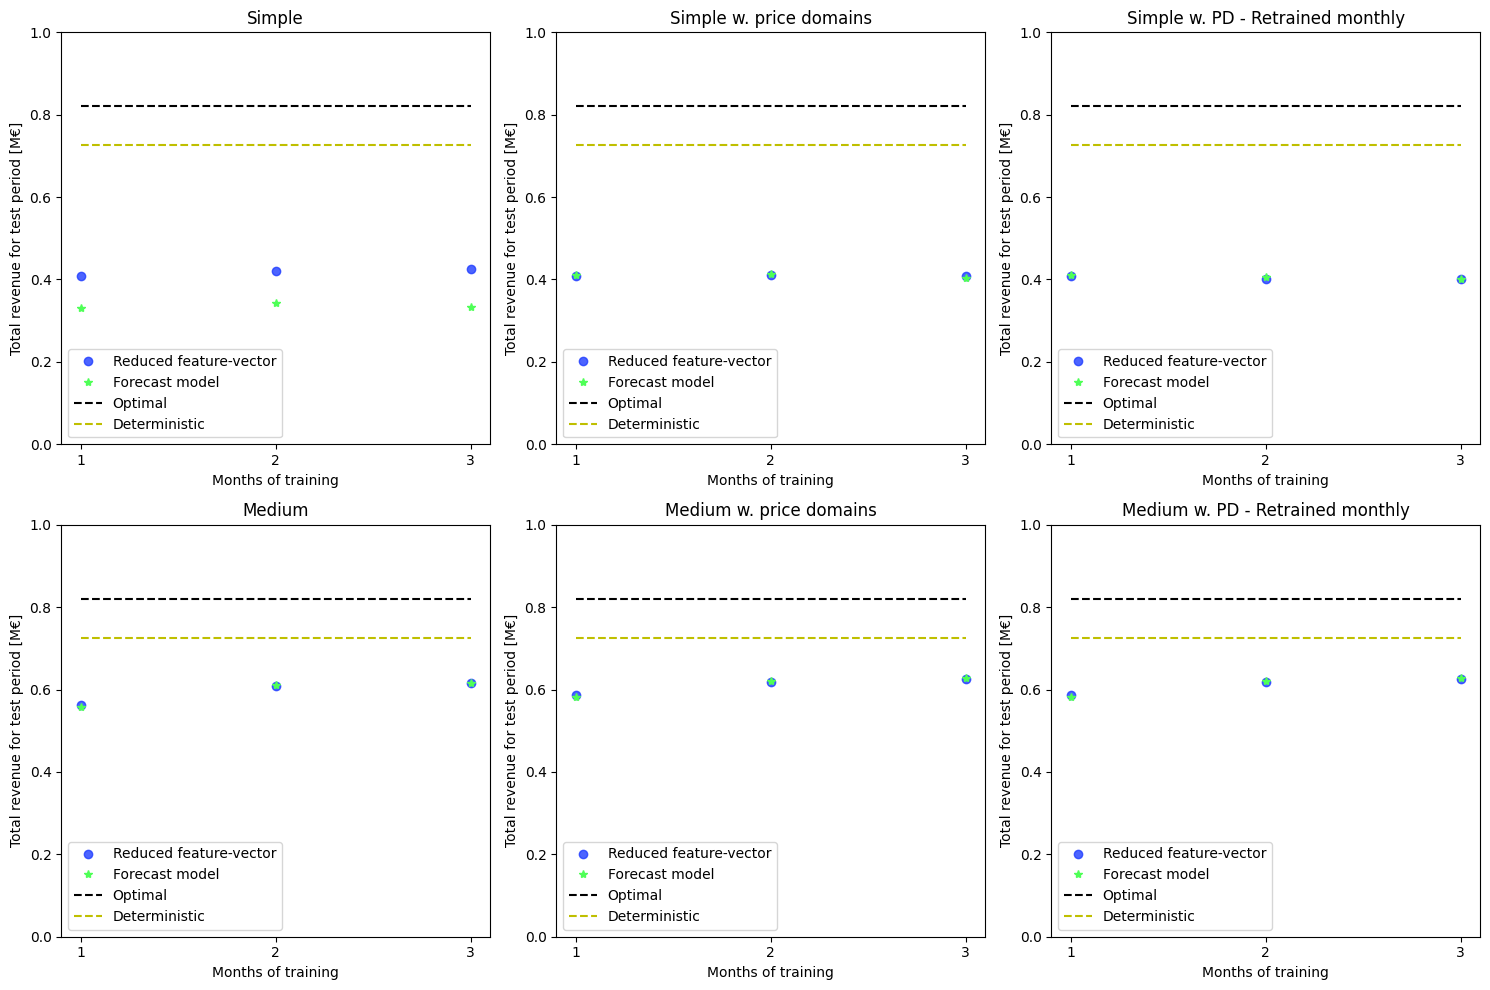

In [436]:

results_to_plot = [
    [results_s_fp, results_s_model],
    [results_m_fp, results_m_model],
    [results_s_fp_PD, results_s_model_PD],
    [results_m_fp_PD, results_m_model_PD],
    [results_s_fp_PD_retrained, results_s_model_PD_retrained],
    [results_m_fp_PD_retrained, results_m_model_PD_retrained]
]

plot_titles = [
    "Simple",
    "Medium",
    "Simple w. price domains",
    "Medium w. price domains",
    "Simple w. PD - Retrained monthly",
    "Medium w. PD - Retrained monthly",
]

fig, axs = plt.subplots(2,3, figsize=(15,10))
xs = range(1,4)
optimals = [np.sum(result_opt['obj'])/(1e6) for _ in xs]
deterministics = [np.sum(result_det['obj'])/(1e6) for _ in xs]
for i, result_list in enumerate(results_to_plot):
    idx2 = int(np.floor((i/2)%3))
    idx1 = int(i%2)
    # print(f"idx1: {idx1}, idx2: {idx2}")
    # axs[idx1, idx2].plot(xs, get_scaled_objs(result_list[0]), color=red, label="All features")
    axs[idx1, idx2].plot(xs, get_scaled_objs(result_list[0]), 'o', color=blue, alpha=0.8, label="Reduced feature-vector")
    axs[idx1, idx2].plot(xs, get_scaled_objs(result_list[1]), '*', color=green, label="Forecast model")
    axs[idx1, idx2].plot(xs, optimals, '--k', label="Optimal")
    axs[idx1, idx2].plot(xs, deterministics, '--y', label="Deterministic")
    axs[idx1, idx2].set_title(plot_titles[i])
    axs[idx1, idx2].legend()
    axs[idx1, idx2].set_xlabel("Months of training")
    axs[idx1, idx2].set_ylabel("Total revenue for test period [M€]")
    axs[idx1, idx2].set_ylim(0, 1)
    axs[idx1, idx2].set_xticks(xs)


# axs[1, 1].plot(xs, results_m_all_PD[0], 'o', color=red, label="All features")
fig.tight_layout()
fig.savefig("2022_results.pdf")



Best is 56.26 % better than General Architecture


C:\Users\emilh\AppData\Local\Temp\ipykernel_11592\3359083918.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=45)
C:\Users\emilh\AppData\Local\Temp\ipykernel_11592\3359083918.py:79: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


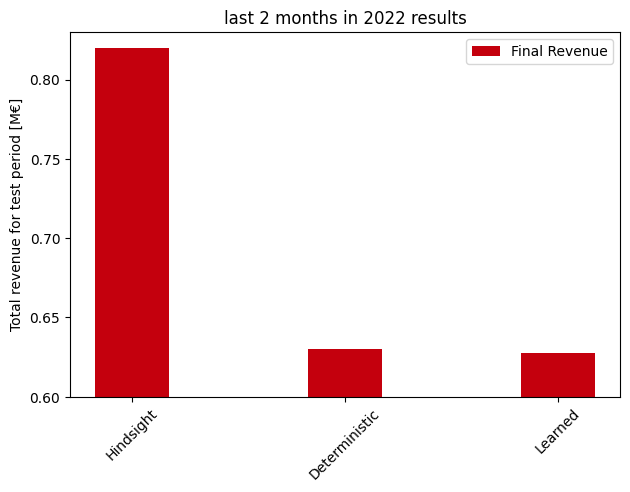

In [461]:
#-------------------INPUTS----------------------
best_res = results_m_model_PD_retrained[2]

strict_det = True
plot_penalties = False
plot_adjustments = False

testname = "General Architecture"
# testname = "Reduced features"
# testname = "No retraining"
# testname = "No price domains"

#-------------------AUTO STUFF----------------------

def result_plot():
    if testname == "General Architecture":
        other_res = results_s_model_PD_retrained[2] # architecture
    elif testname == "Reduced features":
        other_res = results_m_fp_PD_retrained[2] # features
    elif testname == "No retraining":
        other_res = results_m_model_PD[2] # retraining
    elif testname == "No price domains":
        other_res = results_m_model_retrained[2] # price domains

    # other_res = results_m_model_PD_retrained_highpen[2]

    if strict_det:
        det_res = result_det_strict
    else:
        det_res = result_det


    det_up, det_up_dw, det_pp = adjust(det_res)
    best_up, best_up_dw, best_pp = adjust(best_res)
    other_up, other_up_dw, other_pp = adjust(other_res)

    other = results_m_model[2]
    # xlabels = ["Hindsight", "Deterministic", "Learned", testname]
    xlabels = ["Hindsight", "Deterministic", "Learned"]
    # xlabels = ["Hindsight", "Deterministic", "95% quantile penalty", "Max penalty"]
    values = np.array([
        np.sum(result_opt['obj']),
        np.sum(det_res['obj']),
        np.sum(best_res['obj']),
        # np.sum(other_res['obj'])
    ])


    penalties = np.array([
        0, 0, 
        np.sum(best_res['missing_production'])*penalty,
        np.sum(other_res['missing_production'])*penalty
        # np.sum(other_res['missing_production'])*np.max(prices_B)
    ])

    adjustments = np.array([
        0,
        np.sum(det_up_dw['obj'])-np.sum(det_res['obj']),
        np.sum(best_up_dw['obj'])-np.sum(best_res['obj']),
        np.sum(other_up_dw['obj'])-np.sum(other_res['obj'])
    ])

    values *= 1/1e6
    penalties *= 1/1e6
    adjustments *= 1/1e6

    xs = range(len(values))
    width = 0.35
    fig, ax = plt.subplots()
    ax.bar(xs, values, width, color=red, label="Final Revenue")
    if plot_penalties:
        ax.bar(xs, penalties, width, bottom=values, color=blue, label="Penalty Loss")
    if plot_adjustments:
        ax.bar(xs, adjustments, width, bottom=values, color=blue, label="Adjustment Revenue")
    ax.set_xticklabels(xlabels, rotation=45)
    ax.set_xticks(xs)
    ax.set_ylabel("Total revenue for test period [M€]")
    ax.set_ylim(0.6, 0.83)
    fig.show()
    fig.tight_layout()
    ax.legend()
    ax.set_title("last 2 months in 2022 results")
    print("\n")
    print(f"Best is {(np.sum(best_res['obj'])-np.sum(other_res['obj']))/(np.sum(other_res['obj']))*100:.2f} % better than {testname}")
    return fig, ax

fig, ax = result_plot()

# fig.savefig("Impact_of_penalties.pdf")

C:\Users\emilh\AppData\Local\Temp\ipykernel_6340\1711187031.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=45)
C:\Users\emilh\AppData\Local\Temp\ipykernel_6340\1711187031.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


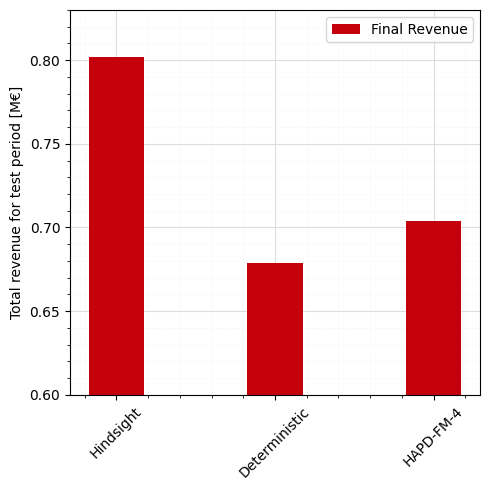

In [18]:

width = 0.35
fig, ax = plt.subplots(figsize=(5,5))
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.minorticks_on()
ax.set_axisbelow(True)
values = np.array([
    np.sum(result_opt_extra['obj']),
    np.sum(result_det_strict_extra['obj']),
    np.sum(results_m_model_PD_mo4[0]['obj'])
])
values *= 1/1e6
xlabels = ["Hindsight", "Deterministic", "HAPD-FM-4"]
xs = range(len(values))
ax.bar(xs, values, width, color=red, label="Final Revenue")
# if plot_penalties:
#     ax.bar(xs, penalties, width, bottom=values, color=blue, label="Penalty Loss")
# if plot_adjustments:
#     ax.bar(xs, adjustments, width, bottom=values, color=blue, label="Adjustment Revenue")
ax.set_xticklabels(xlabels, rotation=45)
ax.set_xticks(xs)
ax.set_ylabel("Total revenue for test period [M€]")
ax.set_ylim(0.6, 0.83)
fig.show()
fig.tight_layout()
ax.legend()
# ax.set_title("last month in 2022 results")
print("\n")
# fig.savefig("./pdfs/2022_results.pdf")
    

In [456]:
values[2]/values[1]

1.0376071479200473

## Wind stuff

27.45 % better with electrolyzer
30.86 % better with electrolyzer when Forecasted


<BarContainer object of 2 artists>

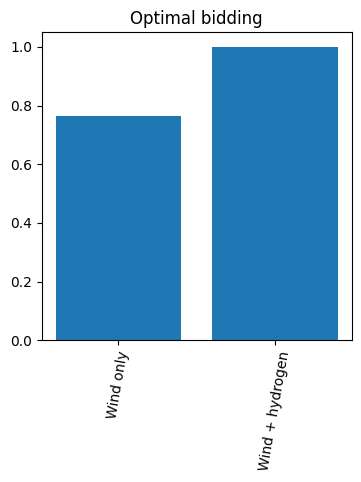

In [5]:

def calc_wind_only(forecasted=True, idx_start=0, idx_end=len(prices_F)):
    wind_only_obj = []
    for t in range(idx_start, idx_end):
        if forecasted:
            forward_bid = forecast[t]
        else:
            forward_bid = realized[t]
        d = realized[t] - forward_bid
        traded = realized[t] - forward_bid
        bought = np.maximum(-traded, 0)
        sold = np.maximum(traded, 0)
        obj = (
            forward_bid * prices_F[t]
            + sold * prices_S[t]
            - bought * prices_B[t]
        )
        wind_only_obj.append(obj)
    return np.sum(wind_only_obj)

def calc_wind_and_hydro(forecasted=True, idx_start=0, idx_end=len(prices_F)):
    wind_and_hydro_obj = []
    for t in range(idx_start, idx_end):
        
        if prices_F[t] > price_H:
            if forecasted:
                forward_bid = forecast[t]
            else:
                forward_bid = realized[t]
        else:
            forward_bid = 0

        forward_bid = np.maximum(forward_bid,0)
        d = realized[t] - forward_bid

        h_prod = get_hydro_opt_dual_price(d, price_H, prices_S[t], prices_B[t], max_elec)
        traded = realized[t] - forward_bid - h_prod
        bought = np.maximum(-traded, 0)
        sold = np.maximum(traded, 0)
        obj = (
            forward_bid * prices_F[t]
            + price_H * h_prod
            + sold * prices_S[t]
            - bought * prices_B[t]
        )
        wind_and_hydro_obj.append(obj)
    return np.sum(wind_and_hydro_obj)
    
xticks = ["Wind only", "Wind + hydrogen"]
obj_values = [calc_wind_only(), calc_wind_and_hydro()]/calc_wind_and_hydro()
idx = np.asarray([i for i in range(len(xticks))])

print(f"{(calc_wind_and_hydro(False)-calc_wind_only(False))/calc_wind_only(False)*100:.2f} % better with electrolyzer")
print(f"{(calc_wind_and_hydro()-calc_wind_only())/calc_wind_only()*100:.2f} % better with electrolyzer when Forecasted")

fig, ax = plt.subplots(figsize = (4,4))
ax.set_xticks(idx, )
ax.set_xticklabels(xticks, rotation=80)
ax.set_title("Optimal bidding")
ax.bar(range(len(obj_values)), obj_values)

## Price analysis

In [326]:
np.quantile(prices_F, 0.95)

580.1935

##### Formatting price data

In [327]:

separated_prices = np.array([prices_F[:-(len(prices_F)-2*month)], prices_F[(len(prices_F)-2*month):]])
separated_prices_days = [[], []]

# Reformat prices to be an array of days
for idx_period, f_prices in enumerate(separated_prices):
    current_day = np.empty(24)
    for i, price in enumerate(f_prices):
        if i%24 == 0 and i != 0:
            separated_prices_days[idx_period].append(current_day)
            current_day = np.empty(24)
        current_day[i%24] = price
    separated_prices_days[idx_period].append(current_day)

# We now have separated_prices_days = [[92 days], [60 days]]

##### Plotting hourly mean prices

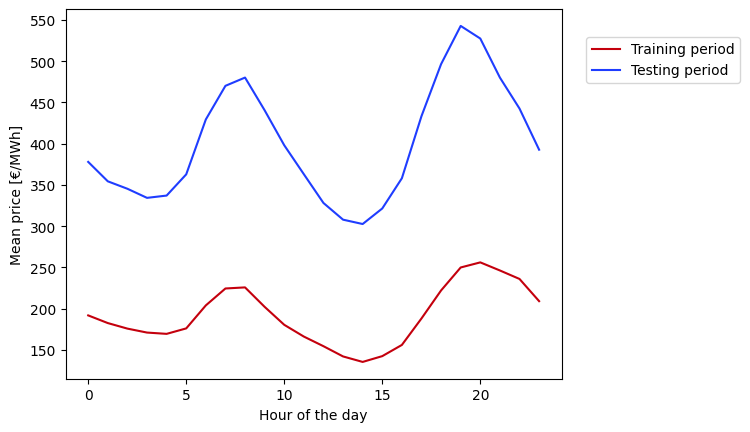

In [328]:

df_train = pd.DataFrame(separated_prices_days[0])
df_test = pd.DataFrame(separated_prices_days[1])
# lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,-0.1))

xs = range(24)
f = plt.figure()
plt.plot(xs, df_train.mean(), label="Training period", color=red)
plt.plot(xs, df_test.mean(), label="Testing period", color=blue)
plt.xlabel("Hour of the day")
plt.ylabel("Mean price [€/MWh]")
lgd = plt.legend(loc=(1.05,0.8))
# plt.grid()
# plt.tight_layout()
plt.show()
f.savefig('mean_prices.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')


##### K-medoids clustering

In [375]:
#-------------K-medoids clustering--------------------
# Find k medoid days in each year
k = 3

# medoids is an array of depth (2(5(24)))
initial_medoids = [price_year[:k] for price_year in separated_prices_days]
final_medoids = []

for idx_period, f_prices in enumerate(separated_prices_days):
    data = np.array(separated_prices_days[idx_period])
    KMobj = KMedoids(n_clusters=k).fit(data)
    # labels = KMobj.labels_
    final_medoids.append(KMobj.cluster_centers_)



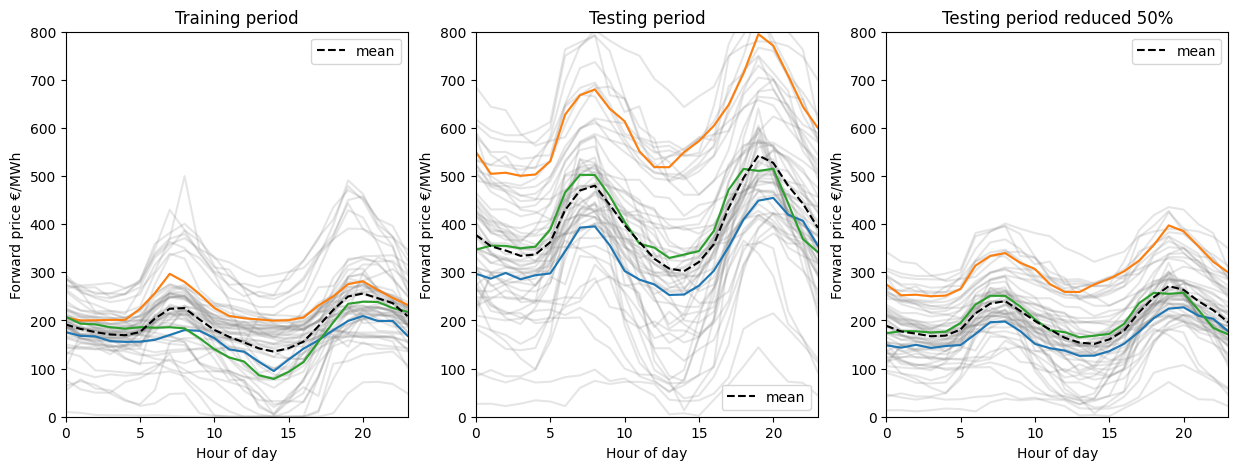

In [376]:
# ---------------Compare medoid days to each other
labels = ["Training period", "Testing period", "Testing period reduced 50%"]
dfs = [df_train, df_test, df_test]
## Plot for each year - good
fig, axs = plt.subplots(1, 3, figsize=(15,5))
for idx, (mlist, ax) in enumerate(zip([*final_medoids, final_medoids[-1]], axs)):
    ax.set_ylim([0, 800])
    ax.set_xlim([0, 23])
    f = 1
    pricedayidx = idx
    if idx == 2:
        f = 0.5
        pricedayidx = 1
    for p in separated_prices_days[pricedayidx]:
        ax.plot(range(24), p*f, "grey", alpha=0.2)
    for m in mlist:
        ax.plot(range(24), m*f)
    ax.plot(range(24), dfs[idx].mean()*f, 'k--', label="mean")
    ax.set_title(labels[idx])
    ax.set_ylabel("Forward price €/MWh")
    ax.set_xlabel("Hour of day")
    ax.legend()
plt.show()
# fig.savefig('k-medoids.pdf')


##### Reduced 2021

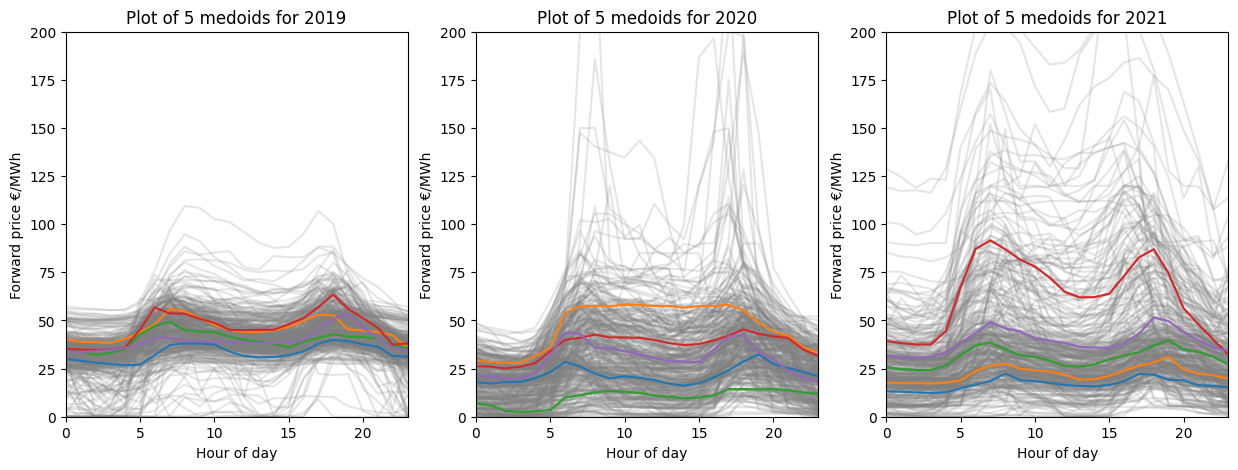

In [12]:
#----------Reduced 2021

fig, axs = plt.subplots(1, 3, figsize=(15,5))
for idx, (mlist, ax) in enumerate(zip(final_medoids, axs)):
    ax.set_ylim([0, 200])
    ax.set_xlim([0, 23])
    if idx != 2:
        for p in yearly_separated_prices_days[idx]:
            ax.plot(range(24), p, "grey", alpha=0.2)
        for m in mlist:
            ax.plot(range(24), m)
    else:
        for p in data_reduced:
            ax.plot(range(24), p, "grey", alpha=0.2)
        for m in reduced_2021_medoids:
            ax.plot(range(24), m)
    ax.set_title(f"Plot of {k} medoids for {labels[idx]}")
    ax.set_ylabel("Forward price €/MWh")
    ax.set_xlabel("Hour of day")
plt.show()
fig.savefig('k-medoids_2021_reduced.pdf')

##### In-depth statistic

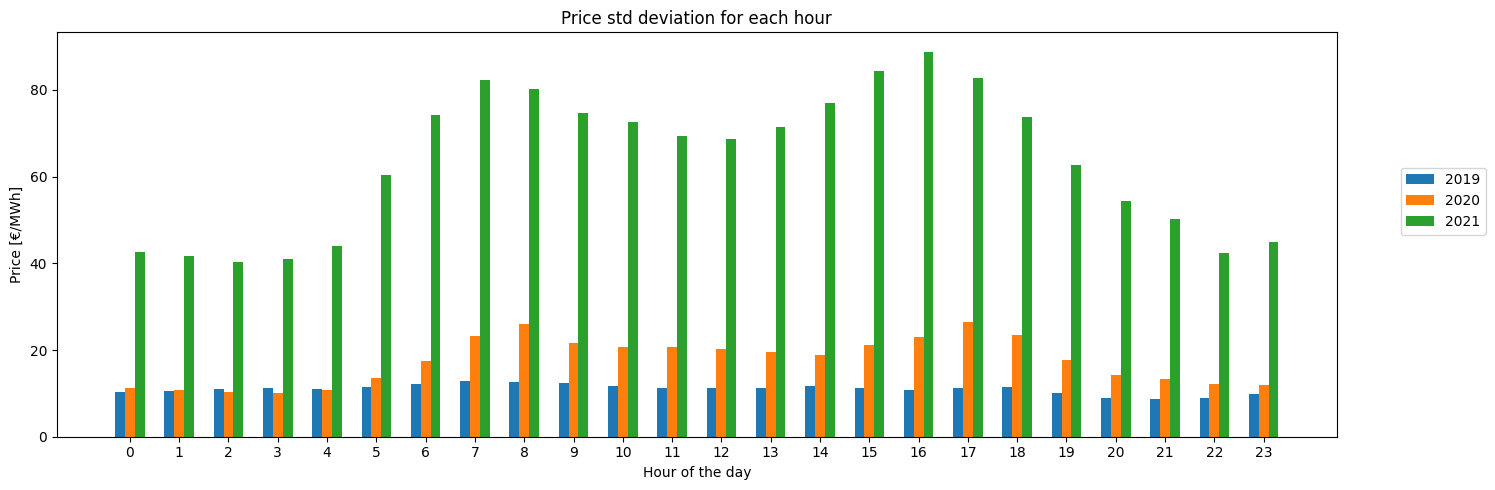

In [270]:
# df_2019.describe()
# df_2020.describe()
# df_2021.describe()


plotlabels = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']
xlabels = range(24)
std_2019 = df_2019.std()
std_2020 = df_2020.std()
std_2021 = df_2021.std()

x = np.arange(len(xlabels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 5))
rects1 = ax.bar(x - width, std_2019, width, label='2019')
rects2 = ax.bar(x, std_2020, width, label='2020')
rects2 = ax.bar(x + width, std_2021, width, label='2021')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Price [€/MWh]')
ax.set_xlabel('Hour of the day')
ax.set_title('Price std deviation for each hour')
ax.set_xticks(x, xlabels)
ax.legend(loc=(1.05,0.5))
fig.tight_layout()
plt.show()


In [18]:
from scipy.stats import wasserstein_distance

v_test = np.array([20-i for i in range(10)])
u_test = np.array([i for i in range(10)])

dist_matrix = np.empty((3,5,5))

all_medoids = [*final_medoids, reduced_2021_medoids]

mean_dists = {
    "2019-2020": 0,
    "2019-2021": 0,
    "2020-2021": 0,
    "2020-2021-red": 0,
    "2019-2021-red": 0,
    "2021-2021-red": 0,
    "2019-2019": 0,
    "2020-2020": 0,
    "2021-2021": 0,
    "2021-red-2021-red": 0
}


years_list = [[0, 1], [0, 2], [1, 2], [1, 3], [0, 3], [2, 3], [0, 0], [1, 1], [2, 2], [3,3]]

for i, key in enumerate(mean_dists.keys()):
    for from_idx in range(5):
        for to_idx in range(5):
            mean_dists[key] += wasserstein_distance(all_medoids[years_list[i][0]][from_idx], all_medoids[years_list[i][1]][to_idx])


mean_dists

# for y_idx in range(3):
#     for i in range(len(yearly_separated_prices_days[years_list[y_idx][0]])):
#         for j in range(len(yearly_separated_prices_days[years_list[y_idx][1]])):
            

{'2019-2020': 377.6045833333334,
 '2019-2021': 1146.2787500000002,
 '2020-2021': 1432.2016666666666,
 '2020-2021-red': 425.37000000000006,
 '2019-2021-red': 396.9585833333333,
 '2021-2021-red': 1349.8748333333333,
 '2019-2019': 135.005,
 '2020-2020': 354.4383333333333,
 '2021-2021': 1089.595,
 '2021-red-2021-red': 435.8380000000001}

In [79]:
len(yearly_separated_prices_days)

3

## Behavior analysis

In [434]:
# KMobj.medoid_indices_
len(prices_F)
df_det_ny = pd.read_csv("./results/2022/deterministic.csv")
df_det_ny.shape

(1440, 2)

In [428]:
# KMobj.medoid_indices_[0]*24
idx  = KMobj.medoid_indices_[0]*24
features.loc[offset+idx:offset+idx+23, "production_FC"]*10

2400    3.229389
2401    3.371517
2402    3.495013
2403    3.595169
2404    3.671316
2405    3.696695
2406    3.696695
2407    3.671316
2408    3.619859
2409    3.568403
2410    3.542325
2411    3.542325
2412    3.542325
2413    3.542325
2414    3.542325
2415    3.567705
2416    3.567705
2417    3.620567
2418    3.726308
2419    4.113133
2420    4.499958
2421    4.895892
2422    5.291827
2423    5.634899
Name: production_FC, dtype: float64

C:\Users\emilh\AppData\Local\Temp\ipykernel_11592\3392515033.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


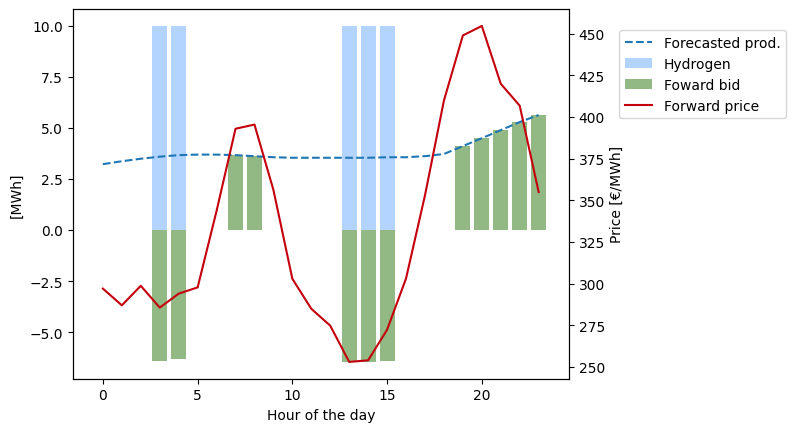

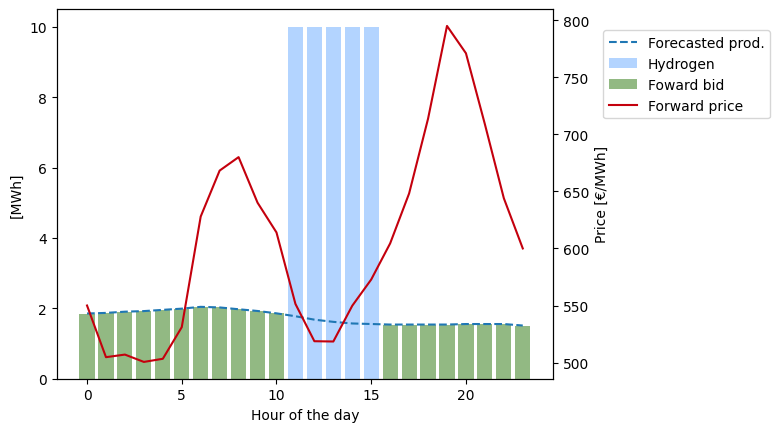

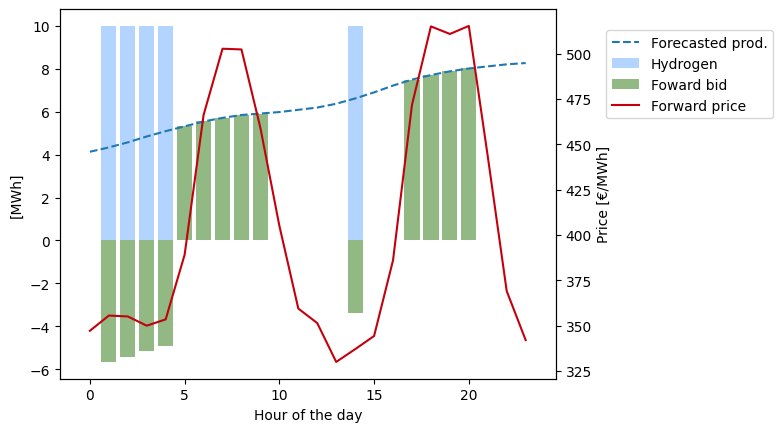

In [438]:


# KMobj.medoid_indices_ # [ 8, 21, 41]


offset = len(prices_F)-2*month
prices_F_test = prices_F[offset:]
prices_B_test = prices_B[offset:]
prices_S_test = prices_S[offset:]

def plot_res(res):
    for plotidx in range(3):
        prods_learned = np.empty(24)
        forward_learned = np.empty(24)
        idx = KMobj.medoid_indices_[plotidx]*24
        for i, t in enumerate(range(idx, idx+24)):
            h = i%24
            prods_learned[h] = res['h_prod'][t]
            forward_learned[h] = res['forward_bid'][t]
        fig, ax = plt.subplots()
        ax.bar(range(24), prods_learned, label="Hydrogen", color=cblue)
        ax.bar(range(24), forward_learned, label="Foward bid", color=cgreen)
        # ax.plot(range(24), realized[offset+idx:offset+idx+24], label="Realized prod.")
        ax.plot(range(24), features.loc[offset+idx:offset+idx+23, "production_FC"]*10, '--', label="Forecasted prod.")
        ax2 = ax.twinx()
        ax2.plot(range(24), prices_F_test[idx:idx+24], color=red, label="Forward price")
        # ax2.plot(range(24), prices_B_test[idx:idx+24], color=blue, label="Deficit price")
        # ax2.plot(range(24), prices_S_test[idx:idx+24], color=green, label="Surplus price")
        # fig.tight_layout()
        ax2.set_ylabel("Price [€/MWh]")
        ax.set_ylabel("[MWh]")
        ax.set_xlabel("Hour of the day")
        fig.legend(bbox_to_anchor=(1.25, 0.85))
        fig.show()

# plot_res(best_res)
plot_res(result_det_strict)
# plot_res(result_opt)





## Production data analysis

##### Formatting production data

In [ ]:
# Reformat prices to be an array of days
for idx_period, f_prices in enumerate(separated_prices):
    current_day = np.empty(24)
    for i, price in enumerate(f_prices):
        if i%24 == 0 and i != 0:
            separated_prices_days[idx_period].append(current_day)
            current_day = np.empty(24)
        current_day[i%24] = price
    separated_prices_days[idx_period].append(current_day)


In [10]:
years = [2019, 2020, 2021]
yearly_separated_prods = np.array([realized[:8760], realized[8760:8760+8784], realized[8760+8784:]])
yearly_separated_prods_days = [[], [], []]

# Reformat prods to be an array of days
for idx_year, f_prods in enumerate(yearly_separated_prods):
    current_day = np.empty(24)
    for i, prod in enumerate(f_prods):
        if i%24 == 0 and i != 0:
            yearly_separated_prods_days[idx_year].append(current_day)
            current_day = np.empty(24)
        current_day[i%24] = prod
    yearly_separated_prods_days[idx_year].append(current_day)

# We now have yearly_separated_prods_days = [[365 days], [366 days], [365 days]]

C:\Users\emilh\AppData\Local\Temp\ipykernel_6340\3730098378.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  yearly_separated_prods = np.array([realized[:8760], realized[8760:8760+8784], realized[8760+8784:]])


##### K-medoids 

In [15]:
#-------------K-medoids clustering--------------------
# Find k medoid days in each year
k = 6

# medoids is an array of depth (3(5(24)))
initial_medoids_prods = [prod_year[:k] for prod_year in yearly_separated_prods_days]
final_medoids_prods = []

for idx_year, f_prices in enumerate(yearly_separated_prods_days):
    data = np.array(yearly_separated_prods_days[idx_year][0])
    KMobj = KMedoids(n_clusters=k).fit(data)
    # labels = KMobj.labels_
    final_medoids_prods.append(KMobj.cluster_centers_)

ValueError: Expected 2D array, got 1D array instead:
array=[0.97236967 1.06192747 1.13520894 1.23502398 1.3250417  1.40927552
 1.39485337 1.41219851 1.40811792 1.35927287 1.31686998 1.27203629
 1.27373054 1.2808096  1.23481599 1.22138493 1.18456904 1.1240112
 1.03285558 0.95421884 0.94828483 0.93767138 0.94482374 0.96832839].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

##### Plotting results

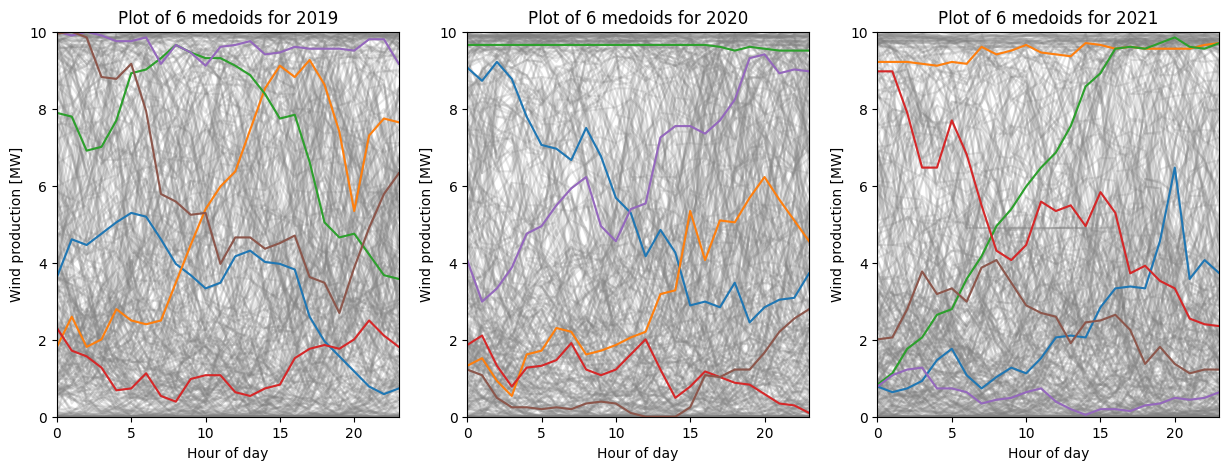

In [13]:
# ---------------Compare medoid days to each other
colors = ["green", "blue", "red"]
labels = ["2019", "2020", "2021"]

## Plot for each year - good
fig, axs = plt.subplots(1, 3, figsize=(15,5))
for idx, (mlist, ax) in enumerate(zip(final_medoids_prods, axs)):
    ax.set_ylim([0, 10])
    ax.set_xlim([0, 23])
    for p in yearly_separated_prods_days[idx]:
        ax.plot(range(24), p, "grey", alpha=0.2)
    for m in mlist:
        ax.plot(range(24), m)
    ax.set_title(f"Plot of {k} medoids for {labels[idx]}")
    ax.set_ylabel("Wind production [MW]")
    ax.set_xlabel("Hour of day")
plt.show()


##### Constructed example plots

In [ ]:

def plot_example_behavior():
    
    (prices_B,prices_S,prices_F,prices_bal,forecast,realized,price_H,max_elec,nominal_wind,penalty) = import_consts()

    year = 8760

    x_max = pd.read_csv("./results/x_max.csv")
    x_max1 = x_max["x_max1"][-year:].to_numpy()
    x_max2 = x_max["x_max2"][-year:].to_numpy()

    wind_last_year = realized[-year:]

    price_last_year = prices_F[-year:]
    hourly_prices = {}
    price_counter = 0
    hourly_prods = {}
    hourly_x1 = {}
    hourly_x2 = {}
    for i in range(24):
        hourly_prices[f"hour_{i}"] = 0
        hourly_prods[f"hour_{i}"] = 0
        hourly_x1[f"hour_{i}"] = 0
        hourly_x2[f"hour_{i}"] = 0
    for i in range(len(price_last_year)):
        # print("Tjek pris: ", price_last_year[i])
        if (price_last_year[i] > 35.2):
            price_counter += 1
            hourly_prices[f"hour_{i % 24}"] += price_last_year[i]
        hourly_prods[f"hour_{i % 24}"] += wind_last_year[i]
        hourly_x1[f"hour_{i%24}"] += x_max1[i]
        hourly_x2[f"hour_{i%24}"] += x_max2[i]

    hydrogen = np.zeros(24)
    adjustments = np.zeros(24)
    
    for i in range(24):
        hourly_prices[f"hour_{i}"] *= 1/(price_counter/24)
        hourly_prods[f"hour_{i}"] *= 1/(year/24)
        hourly_x1[f"hour_{i}"] *= 1/(year/24)
        hourly_x2[f"hour_{i}"] *= 1/(year/24)
            

    adjustments[2:4] = 10
    for i in range(5):
        hourly_prices[f"hour_{i}"] += 20

    for i in range(11, 15):
        
        hourly_prices[f"hour_{i}"] -= 20

    hydrogen[12:15] += 10
    hydrogen[-2:] += 10
    adjustments[-2:] = - 10
    prices = hourly_prices.values()
    x1s = hourly_x1.values()
    x2s = hourly_x2.values()

    prices_bal = np.array([hourly_prices[f"hour_{i}"] for i in range(24)])
    prices_bal[2:4] -= 50

    prices_bal[10:14] -= 4
    prices_bal[20] += 30
    prices_bal[23] += 40
    plt.bar(range(24), prices, label="Forward prices")
    # plt.bar(range(24), x1s)
    plt.plot(range(24), prices_bal, 'r', label="Balancing price")
    
    plt.bar(range(24), hydrogen, label="hydrogen production")
    plt.bar(range(24), adjustments, label="Adjustment")
    plt.legend()
    plt.title("Adjustment example")

    # plt.bar(range(len(price_last_two_months)), price_last_two_months)
    # print("Hydrogen prouction: ", np.sum(hydrogen))
plot_example_behavior()

In [ ]:

def plot_example_behavior_no_adj():
    
    (prices_B,prices_S,prices_F,prices_bal,forecast,realized,price_H,max_elec,nominal_wind,penalty) = import_consts()

    year = 8760

    x_max = pd.read_csv("./results/x_max.csv")
    x_max1 = x_max["x_max1"][-year:].to_numpy()
    x_max2 = x_max["x_max2"][-year:].to_numpy()

    wind_last_year = realized[-year:]

    price_last_year = prices_F[-year:]
    hourly_prices = {}
    price_counter = 0
    hourly_prods = {}
    hourly_x1 = {}
    hourly_x2 = {}
    for i in range(24):
        hourly_prices[f"hour_{i}"] = 0
        hourly_prods[f"hour_{i}"] = 0
        hourly_x1[f"hour_{i}"] = 0
        hourly_x2[f"hour_{i}"] = 0
    for i in range(len(price_last_year)):
        # print("Tjek pris: ", price_last_year[i])
        if (price_last_year[i] > 35.2):
            price_counter += 1
            hourly_prices[f"hour_{i % 24}"] += price_last_year[i]
        hourly_prods[f"hour_{i % 24}"] += wind_last_year[i]
        hourly_x1[f"hour_{i%24}"] += x_max1[i]
        hourly_x2[f"hour_{i%24}"] += x_max2[i]

    hydrogen = np.zeros(24)
    adjustments = np.zeros(24)
    
    for i in range(24):
        hourly_prices[f"hour_{i}"] *= 1/(price_counter/24)
        hourly_prods[f"hour_{i}"] *= 1/(year/24)
        hourly_x1[f"hour_{i}"] *= 1/(year/24)
        hourly_x2[f"hour_{i}"] *= 1/(year/24)
            

    adjustments[2:4] = 10
    for i in range(5):
        hourly_prices[f"hour_{i}"] += 20

    for i in range(11, 15):
        
        hourly_prices[f"hour_{i}"] -= 20

    hydrogen[12:15] += 10
    hydrogen[-2:] += 10
    adjustments[-2:] = - 10
    prices = hourly_prices.values()
    x1s = hourly_x1.values()
    x2s = hourly_x2.values()

    prices_bal = np.array([hourly_prices[f"hour_{i}"] for i in range(24)])
    prices_bal[2:4] -= 50

    prices_bal[10:14] += 30
    prices_bal[20] += 30
    prices_bal[23] += 40
    plt.bar(range(24), prices, label="Forward prices")
    # plt.bar(range(24), x1s)
    # plt.plot(range(24), prices_bal, 'r', label="Balancing price")
    
    plt.bar(range(24), hydrogen, label="hydrogen production")
    # plt.bar(range(24), adjustments, label="Adjustment")
    plt.legend()
    plt.title("Deterministic example")

    # plt.bar(range(len(price_last_two_months)), price_last_two_months)
    # print("Hydrogen prouction: ", np.sum(hydrogen))
plot_example_behavior_no_adj()

In [ ]:

def plot_deterministic_behavior():
    
    (prices_B,prices_S,prices_F,prices_bal,forecast,realized,price_H,max_elec,nominal_wind,penalty) = import_consts()

    year = 8760

    x_max = pd.read_csv("./results/x_max.csv")
    x_max1 = x_max["x_max1"][-year:].to_numpy()
    x_max2 = x_max["x_max2"][-year:].to_numpy()

    wind_last_year = realized[-year:]

    price_last_year = prices_F[-year:]
    hourly_prices = {}
    price_counter = 0
    hourly_prods = {}
    hourly_x1 = {}
    hourly_x2 = {}
    for i in range(24):
        hourly_prices[f"hour_{i}"] = 0
        hourly_prods[f"hour_{i}"] = 0
        hourly_x1[f"hour_{i}"] = 0
        hourly_x2[f"hour_{i}"] = 0
    for i in range(len(price_last_year)):
        # print("Tjek pris: ", price_last_year[i])
        if (price_last_year[i] > 35.2):
            price_counter += 1
            hourly_prices[f"hour_{i % 24}"] += price_last_year[i]
        hourly_prods[f"hour_{i % 24}"] += wind_last_year[i]
        hourly_x1[f"hour_{i%24}"] += x_max1[i]
        hourly_x2[f"hour_{i%24}"] += x_max2[i]

    hydrogen = np.zeros(24)
    
    for i in range(24):
        hourly_prices[f"hour_{i}"] *= 1/(price_counter/24)
        hourly_prods[f"hour_{i}"] *= 1/(year/24)
        hourly_x1[f"hour_{i}"] *= 1/(year/24)
        hourly_x2[f"hour_{i}"] *= 1/(year/24)
        if i < 5:
            hydrogen[i] += 10


    prices = hourly_prices.values()
    x1s = hourly_x1.values()
    x2s = hourly_x2.values()


    plt.bar(range(24), prices, label="Forward prices")
    # plt.bar(range(24), x1s)
    # plt.bar(range(24), forward, label="forward bid")
    plt.bar(range(24), hydrogen, label="hydrogen production")
    plt.legend()
    plt.title("Deterministic behavior")

    # plt.bar(range(len(price_last_two_months)), price_last_two_months)
    # print("Hydrogen prouction: ", np.sum(hydrogen))


plot_deterministic_behavior()

In [ ]:

def plot_mean_behavior(df_qs):
    
    (prices_B,prices_S,prices_F,prices_bal,forecast,realized,price_H,max_elec,nominal_wind,penalty) = import_consts()

    year = 8760

    x_max = pd.read_csv("./results/x_max.csv")
    x_max1 = x_max["x_max1"][-year:].to_numpy()
    x_max2 = x_max["x_max2"][-year:].to_numpy()

    wind_last_year = realized[-year:]

    price_last_year = prices_F[-year:]
    hourly_prices = {}
    price_counter = 0
    hourly_prods = {}
    hourly_x1 = {}
    hourly_x2 = {}
    for i in range(24):
        hourly_prices[f"hour_{i}"] = 0
        hourly_prods[f"hour_{i}"] = 0
        hourly_x1[f"hour_{i}"] = 0
        hourly_x2[f"hour_{i}"] = 0
    for i in range(len(price_last_year)):
        # print("Tjek pris: ", price_last_year[i])
        if (price_last_year[i] > 35.2):
            price_counter += 1
            hourly_prices[f"hour_{i % 24}"] += price_last_year[i]
        hourly_prods[f"hour_{i % 24}"] += wind_last_year[i]
        hourly_x1[f"hour_{i%24}"] += x_max1[i]
        hourly_x2[f"hour_{i%24}"] += x_max2[i]

    for i in range(24):
        hourly_prices[f"hour_{i}"] *= 1/(price_counter/24)
        hourly_prods[f"hour_{i}"] *= 1/(year/24)
        hourly_x1[f"hour_{i}"] *= 1/(year/24)
        hourly_x2[f"hour_{i}"] *= 1/(year/24)


    prices = hourly_prices.values()
    prods = hourly_prods.values()
    x1s = hourly_x1.values()
    x2s = hourly_x2.values()
    hydrogen = []
    forward = []
    for i, prod, price in zip(range(24), x1s, x2s):
        hydrogen.append(np.maximum((df_qs["qH1"][i]*prod + df_qs["qH2"][i]*price + df_qs["qH3"][i]),0))
        if (price > 35.2):
            forward.append(np.maximum((df_qs["qF1"][i]*prod + df_qs["qF2"][i]*price + df_qs["qF3"][i]),0))
        else:
            forward.append(0)

        # print(f'For hour {i}, FC={prod}, FP={price}, FB={(df_qs["qF1"][i]*prod + df_qs["qF2"][i]*price + df_qs["qF3"][i])}, H={(df_qs["qH1"][i]*prod + df_qs["qH2"][i]*price + df_qs["qH3"][i])}')
        

    balancing_price = np.array([hourly_prices[f"hour_{i}"] for i in range(24)])
    balancing_price[:5] += 35
    balancing_price[11:15] -= 20
    plt.bar(range(24), prices, label="Forward prices")
    # plt.bar(range(24), x1s)
    # plt.bar(range(24), forward, label="forward bid")
    plt.plot(range(24), balancing_price, 'r', label="balancing price")
    plt.bar(range(24), hydrogen, label="hydrogen production")
    plt.legend()
    plt.title("Learned behavior")

    # plt.bar(range(len(price_last_two_months)), price_last_two_months)
    print("Hydrogen prouction: ", np.sum(hydrogen))


df_initial = pd.read_csv("./results/RES_05.2_mo_24_5.csv")
plot_mean_behavior(df_initial)

## Comparing different models - 2021

In [ ]:
#----------Price domain retrained different periods
idx_end = len(prices_F)
idx_start = idx_end - 8760
print("Before printing")
results_pd_retraining = []
for i in range(24):
    init_filename = './results/RES_05.2_01_price_domain_mo21.csv'
    cqs_filename = f'./results/changing_qs_price_domain/{i+1}_month_training/RES_05.2_01_price_domain_retrained_mo'
    results = test_price_domain_changing_qs(init_filename, cqs_filename, idx_start, idx_end)
    results_pd_retraining.append(results)
    print(f"{i+1} month training: ", np.sum(results['obj']))

print("Done printing")
objs_pd_retraining = [np.sum(result['obj']) for result in results_pd_retraining]

In [100]:

idx_start = len(prices_F)-8760
idx_end = len(prices_F)

# #---------Changing qs for medium 
# init_filename = './results/RES_05.2_mo_24_5.csv'
# cqs_filename = './results/changing_qs/RES_05.2_FINAL_v'
# result_cqs = test_initial_plan_changing_qs(init_filename, cqs_filename, idx_start, idx_end)

#-------18 months is best
result_pd_cqs = results_pd_retraining[np.argmax(objs_pd_retraining)]
result_pd_cqs_for_risky = results_pd_retraining[np.argmax(objs_pd_retraining)]
result_pd_cqs_risky = apply_risky_policy(result_pd_cqs_for_risky, idx_start, idx_end)

df_det = pd.read_csv('./results/RES_05.2_d_good_FC.csv')
det = test_optimal(df_det["forward bid"], df_det["hydrogen production"], idx_start, idx_end)
det_for_risky = test_optimal(df_det["forward bid"], df_det["hydrogen production"], idx_start, idx_end)
det_plus_risky = apply_risky_policy(det_for_risky, idx_start, idx_end)

# Oracle price domain
# df_price_domain_oracle = pd.read_csv('./results/RES_05.2_01_price_domain_oracle.csv')
# results_price_domain_oracle = test_price_domain(df_price_domain_oracle, idx_start, idx_end)

# Optimal everything
df_o_everything = pd.read_csv("./results/RES_05.2_o_everything.csv")
results_o = test_optimal(df_o_everything.iloc[:,1], df_o_everything.iloc[:,0], idx_start, idx_end)


Best learned revenue is 83.29 % of Optimal
Deterministic revenue is 68.34 % of Optimal


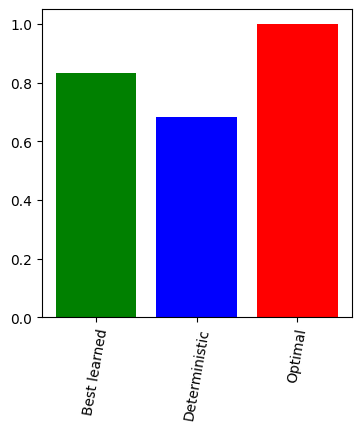

In [102]:
#------------------Without adjustment-------------

xticks = ["Best learned", "Deterministic", "Optimal"]
obj_values_1v24 = [np.sum(result_pd_cqs['obj']), np.sum(det['obj']), np.sum(results_o['obj'])]/np.sum(results_o['obj'])
colors = ['green', 'blue','red']



fig, ax = plot_resulting_objectives(obj_values_1v24, xticks, (4,4), colors=colors)

# fig.savefig('2021_results.pdf')

#### With adjustment

Best learned + adj revenue is 85.37 % of Optimal
Deterministic revenue is 79.40 % of Optimal


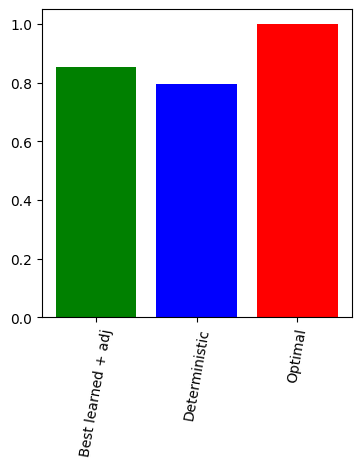

In [103]:
#------------------With adjustment-------------
xticks = ["Best learned + adj", "Deterministic", "Optimal"]
obj_values_1v24 = [np.sum(result_pd_cqs_risky['obj']), np.sum(det_plus_risky['obj']), np.sum(results_o['obj'])]/np.sum(results_o['obj'])
colors = ["green", "blue", "red"]

idx = np.asarray([i for i in range(len(xticks))])

fig, ax = plot_resulting_objectives(obj_values_1v24, xticks, (4,4), colors=colors)

# fig.savefig('2021_adj_results.pdf')

##### Changing prices

**If we reduce prices to 40%:**

Leaned domains + adj revenue is 97.08 % of Optimal

Det. FC prices + adj revenue is 96.75 % of Optimal

Det. FC price+prod + adj revenue is 96.98 % of Optimal

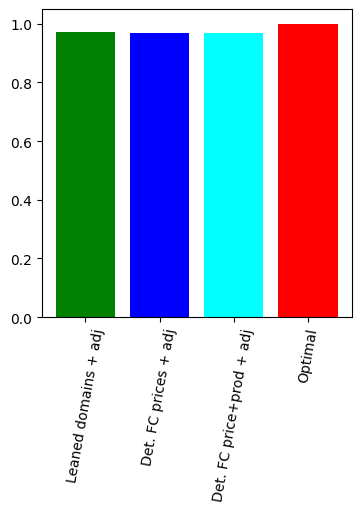

**Original prices:**

Leaned domains + adj revenue is 85.27 % of Optimal

Det. FC prices + adj revenue is 87.57 % of Optimal

Det. FC price+prod + adj revenue is 91.61 % of Optimal

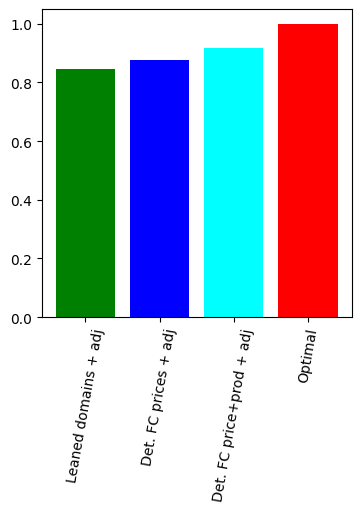

In [ ]:
#-------------------------COMPLEX
def complex_initial_easy_tester(resultfilename):
    idx_end = len(prices_F)
    idx_start = idx_end-8760
    df = pd.read_csv(f'./results/RES_05.2_{resultfilename}.csv')
    df_f = pd.DataFrame(df[["qF1", "qF2", "qF3"]])
    df_h = pd.DataFrame(df[["qH1", "qH2", "qH3"]])
    results = test_initial_plan(df_f, df_h, idx_start, idx_end, False)
    return results

for i, obj in enumerate([np.sum(results_mo1['obj']), np.sum(results_mo2['obj']), np.sum(results_mo3['obj']), np.sum(results_mo4['obj']), np.sum(results_mo5['obj']), np.sum(results_mo6['obj']), np.sum(results_mo7['obj'])]):
    print(f"Objective value {i+1} month long training: {obj}")
# print("Testing on entire year of 2021")


## Comparing different models - 2020

In [105]:
idx_start = len(prices_F)-8760*2
idx_end = len(prices_F)-8760
#------------------------------2020 different training periods

results_price_domains = []

for i in range(12):
    df = pd.read_csv(f'./results/2020/RES_05.2_01_price_domain_mo{i+1}.csv')
    res = test_price_domain(df, idx_start, idx_end)
    results_price_domains.append(res)
    print(i+1, " months: ", np.sum(res['obj']))


1  months:  1528509.9079636433
2  months:  1611479.2298431632
3  months:  1618397.2207287974
4  months:  1618904.6233922425
5  months:  1621603.923744644
6  months:  1619635.6545720906
7  months:  1613496.4165171366
8  months:  1613729.257402501
9  months:  1614003.6262537052
10  months:  1613564.6967569012
11  months:  1614447.6400987953
12  months:  1615621.0399191391


In [107]:
#----------Price domain retrained different periods
idx_start = len(prices_F)-8760*2
idx_end = len(prices_F)-8760

results_pd_retraining = []
for i in range(12):
    init_filename = './results/2020/RES_05.2_01_price_domain_mo4.csv'
    cqs_filename = f'./results/2020/changing_qs_price_domain/{i+1}_month_training/RES_05.2_01_price_domain_retrained_mo'
    results = test_price_domain_changing_qs(init_filename, cqs_filename, idx_start, idx_end)
    results_pd_retraining.append(results)
    print(f"{i+1} month training: ", np.sum(results['obj']))

objs_pd_retraining = [np.sum(result['obj']) for result in results_pd_retraining]

1 month training:  1499134.394718748
2 month training:  1550916.2087326373
3 month training:  1563952.292966933
4 month training:  1561705.3903655182
5 month training:  1561670.8440418816
6 month training:  1568892.952808013
7 month training:  1576736.9095234517
8 month training:  1578756.7687784184
9 month training:  1601763.9962879634
10 month training:  1613279.0195606186
11 month training:  1616946.3718301333
12 month training:  1617339.7629796225


In [108]:

idx_start = len(prices_F)-8760*2
idx_end = len(prices_F)-8760

init_filename = './results/2020/RES_05.2_01_price_domain_mo12.csv'
cqs_filename = f'./results/2020/changing_qs_price_domain/changing_training/RES_05.2_trained_2_price_domain_retrained_mo'
# cqs_filename = f'./results/2020/changing_qs_price_domain/12_month_training/RES_05.2_01_price_domain_retrained_mo'
result_pd_cqs = test_price_domain_changing_qs(init_filename, cqs_filename, idx_start, idx_end)
result_pd_cqs_for_risky = test_price_domain_changing_qs(init_filename, cqs_filename, idx_start, idx_end)
result_pd_cqs_risky = apply_risky_policy(result_pd_cqs_for_risky, idx_start, idx_end)

df_det = pd.read_csv('./results/2020/RES_05.2_d_good_FC.csv')

det = test_optimal(df_det["forward bid"], df_det["hydrogen production"], idx_start, idx_end)
det_for_risky = test_optimal(df_det["forward bid"], df_det["hydrogen production"], idx_start, idx_end)
det_plus_risky = apply_risky_policy(det_for_risky, idx_start, idx_end)

# Oracle price domain
# df_price_domain_oracle = pd.read_csv('./results/2020/RES_05.2_01_price_domain_oracle.csv')
# results_price_domain_oracle = test_price_domain(df_price_domain_oracle, idx_start, idx_end)

# Optimal everything
df_o_everything = pd.read_csv("./results/2020/RES_05.2_o_everything.csv")
results_o = test_optimal(df_o_everything.iloc[:,1], df_o_everything.iloc[:,0], idx_start, idx_end)



FileNotFoundError: [Errno 2] No such file or directory: './results/2020/changing_qs_price_domain/changing_training/RES_05.2_trained_2_price_domain_retrained_mo1.csv'

Best learned is 87.76 % of optimal
Det. FC prices is 57.12 % of optimal
Det. FC price+prod is 76.48 % of optimal


C:\Users\emilh\AppData\Local\Temp\ipykernel_24728\1233032468.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


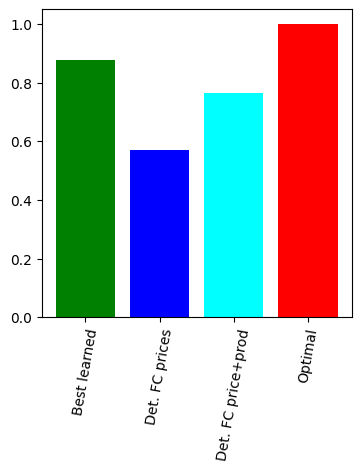

In [ ]:

#------------------Without adjustment-------------
xticks = ["Best learned", "Det. FC prices", "Det. FC price+prod", "Optimal"]
obj_values_1v24 = [np.sum(result_pd_cqs['obj']), np.sum(det_std['obj']), np.sum(det_good_FC['obj']), np.sum(results_o['obj'])]/np.sum(results_o['obj'])
colors = ['green', 'blue', 'cyan', 'red']

fig, ax = plt.subplots(figsize=(4,4))
xs = range(len(xticks))
ax.bar(xs, obj_values_1v24, color=colors)
ax.set_xticks(xs)
ax.set_xticklabels(xticks, rotation=80)


for i in range(len(xticks)-1):
    print(f"{xticks[i]} is {obj_values_1v24[i]/obj_values_1v24[-1]*100:.2f} % of optimal")

fig.savefig('2020_results.pdf')
fig.show()

Best learned is 85.37 % of optimal
Det. mean prices is 79.40 % of optimal
Det. FC price+prod is 79.70 % of optimal


C:\Users\emilh\AppData\Local\Temp\ipykernel_24728\3682764570.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


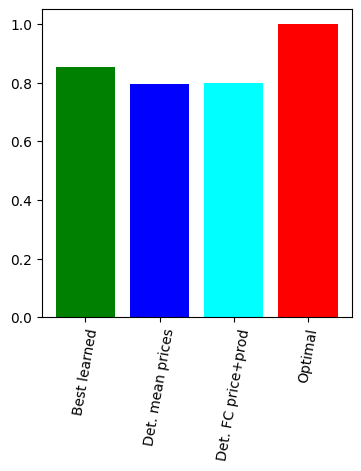

In [109]:
#------------------With adjustment-------------
xticks = ["Best learned", "Det. mean prices", "Det. FC price+prod", "Optimal"]
obj_values_1v24 = [np.sum(result_pd_cqs_risky['obj']), np.sum(det_plus_risky['obj']), np.sum(det_good_FC_plus_risky['obj']), np.sum(results_o['obj'])]/np.sum(results_o['obj'])
colors = ['green', 'blue', 'cyan', 'red']



fig, ax = plt.subplots(figsize=(4,4))
xs = range(len(xticks))
ax.bar(xs, obj_values_1v24, color=colors)
ax.set_xticks(xs)
ax.set_xticklabels(xticks, rotation=80)

for i in range(len(xticks)-1):
    print(f"{xticks[i]} is {obj_values_1v24[i]/obj_values_1v24[-1]*100:.2f} % of optimal")

fig.show()

fig.savefig('2020_adj_results.pdf')

## Comparing different models - 2021 - reduced prices

In [67]:

idx_start = len(prices_F)-8760
idx_end = len(prices_F)

init_filename = './results/2021_red/RES_05.2_01_price_domain_mo12.csv'
cqs_filename = f'./results/2021_red/changing_qs_price_domain/12_month_training/RES_05.2_01_price_domain_retrained_mo'
# cqs_filename = f'./results/2020/changing_qs_price_domain/12_month_training/RES_05.2_01_price_domain_retrained_mo'
result_pd_cqs = test_price_domain_changing_qs(init_filename, cqs_filename, idx_start, idx_end)
result_pd_cqs_for_risky = test_price_domain_changing_qs(init_filename, cqs_filename, idx_start, idx_end)
result_pd_cqs_risky = apply_risky_policy(result_pd_cqs_for_risky, idx_start, idx_end)

df_det = pd.read_csv('./results/2021_red/RES_05.2_d_FC.csv')
df_det_good_FC = pd.read_csv('./results/2021_red/RES_05.2_d_good_FC.csv')

det_std = test_optimal(df_det["forward bid"], df_det["hydrogen production"], idx_start, idx_end)
det_for_risky = test_optimal(df_det["forward bid"], df_det["hydrogen production"], idx_start, idx_end)
det_plus_risky = apply_risky_policy(det_for_risky, idx_start, idx_end)

det_good_FC = test_optimal(df_det_good_FC["forward bid"], df_det_good_FC["hydrogen production"], idx_start, idx_end)
det_good_FC_for_risky = test_optimal(df_det_good_FC["forward bid"], df_det_good_FC["hydrogen production"], idx_start, idx_end)
det_good_FC_plus_risky = apply_risky_policy(det_good_FC_for_risky, idx_start, idx_end)

det_mean = test_optimal(df_det_mean["forward bid"], df_det_mean["hydrogen production"], idx_start, idx_end)

# Oracle price domain
# df_price_domain_oracle = pd.read_csv('./results/2020/RES_05.2_01_price_domain_oracle.csv')
# results_price_domain_oracle = test_price_domain(df_price_domain_oracle, idx_start, idx_end)

# Optimal everything
df_o_everything = pd.read_csv("./results/2021_red/RES_05.2_o_everything.csv")
results_o = test_optimal(df_o_everything.iloc[:,1], df_o_everything.iloc[:,0], idx_start, idx_end)



Best learned is 83.64 % of optimal
Det. FC prices is 64.25 % of optimal
Det. FC price+prod is 72.37 % of optimal


C:\Users\emilh\AppData\Local\Temp\ipykernel_24728\1689033366.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


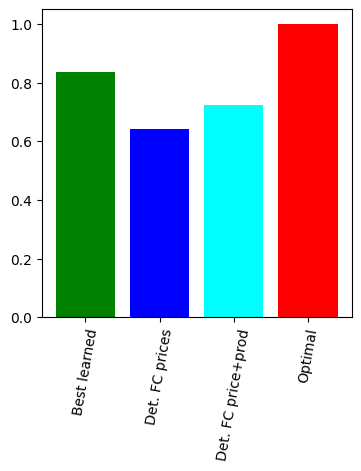

In [68]:

#------------------Without adjustment-------------
xticks = ["Best learned", "Det. FC prices", "Det. FC price+prod", "Optimal"]
obj_values_1v24 = [np.sum(result_pd_cqs['obj']), np.sum(det_std['obj']), np.sum(det_good_FC['obj']), np.sum(results_o['obj'])]/np.sum(results_o['obj'])
colors = ['green', 'blue', 'cyan', 'red']

fig, ax = plt.subplots(figsize=(4,4))
xs = range(len(xticks))
ax.bar(xs, obj_values_1v24, color=colors)
ax.set_xticks(xs)
ax.set_xticklabels(xticks, rotation=80)


for i in range(len(xticks)-1):
    print(f"{xticks[i]} is {obj_values_1v24[i]/obj_values_1v24[-1]*100:.2f} % of optimal")

fig.savefig('2021_red_results.pdf')
fig.show()

Best learned is 88.55 % of optimal
Det. mean prices is 96.75 % of optimal
Det. FC price+prod is 96.98 % of optimal


C:\Users\emilh\AppData\Local\Temp\ipykernel_24728\2498853077.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


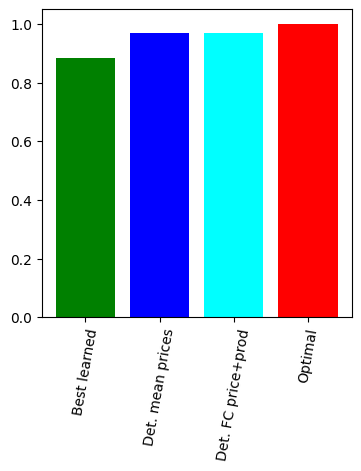

In [69]:
#------------------With adjustment-------------
xticks = ["Best learned", "Det. mean prices", "Det. FC price+prod", "Optimal"]
obj_values_1v24 = [np.sum(result_pd_cqs_risky['obj']), np.sum(det_plus_risky['obj']), np.sum(det_good_FC_plus_risky['obj']), np.sum(results_o['obj'])]/np.sum(results_o['obj'])
colors = ['green', 'blue', 'cyan', 'red']



fig, ax = plt.subplots(figsize=(4,4))
xs = range(len(xticks))
ax.bar(xs, obj_values_1v24, color=colors)
ax.set_xticks(xs)
ax.set_xticklabels(xticks, rotation=80)

for i in range(len(xticks)-1):
    print(f"{xticks[i]} is {obj_values_1v24[i]/obj_values_1v24[-1]*100:.2f} % of optimal")

fig.show()

fig.savefig('2021_red_adj_results.pdf')

## Some investigation with kind of nice plots maybe

Day is 110


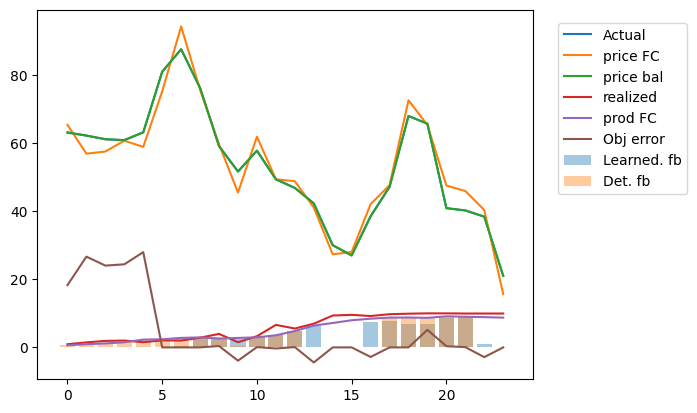

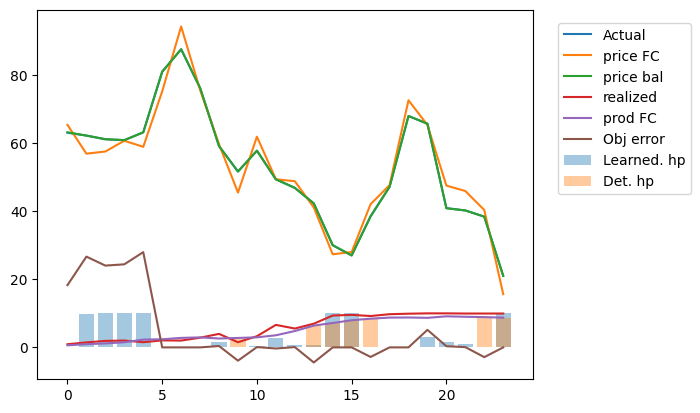

Day is 148


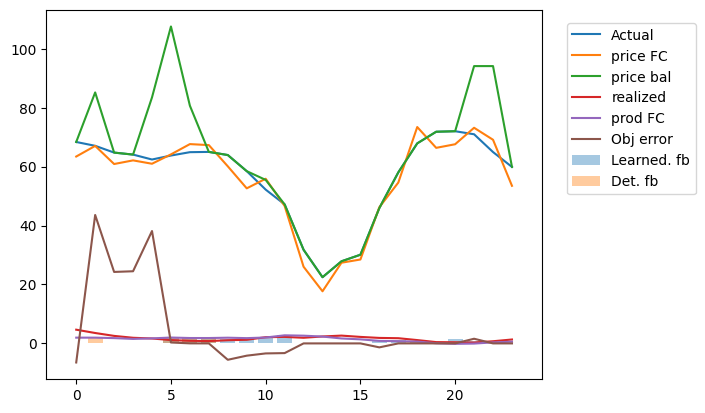

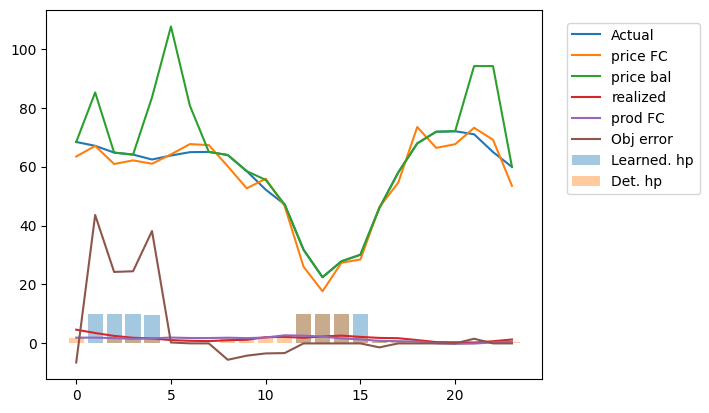

Day is 162


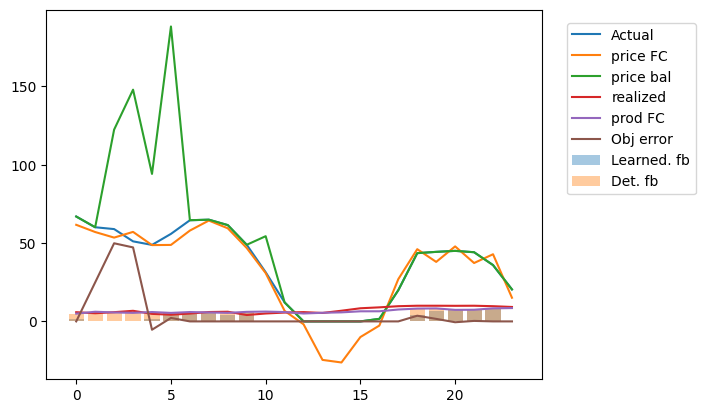

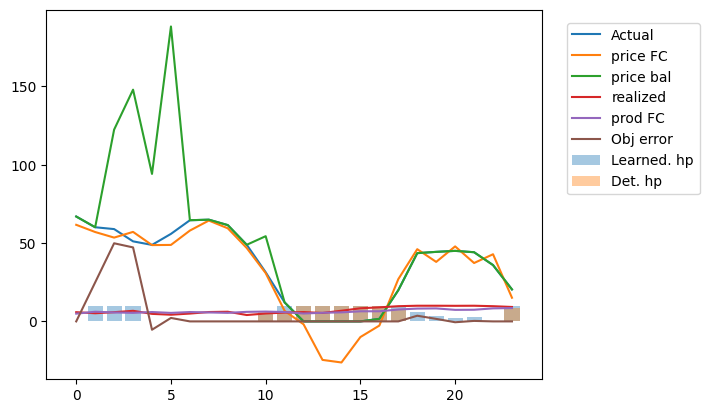

Day is 177


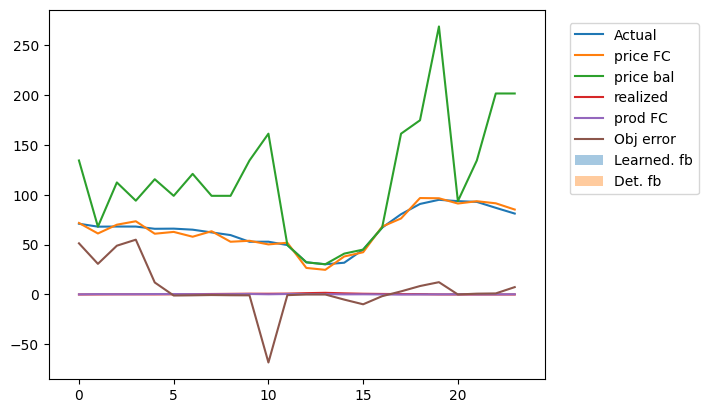

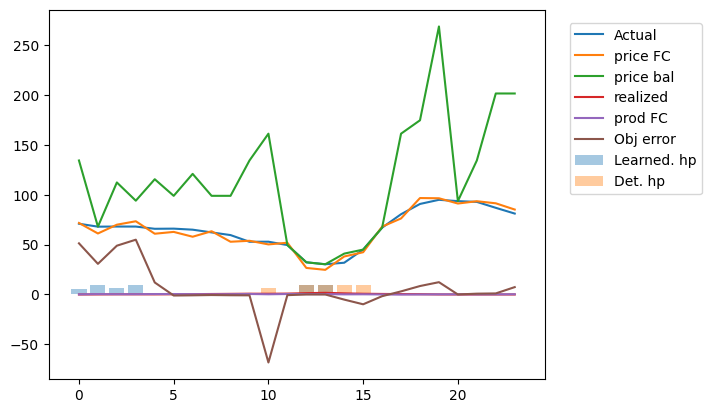

Day is 197


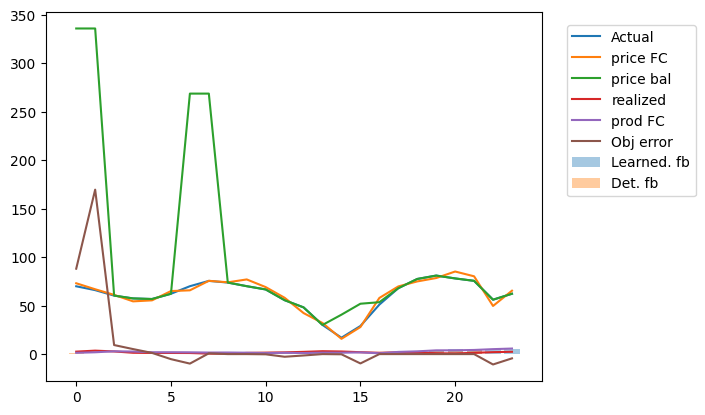

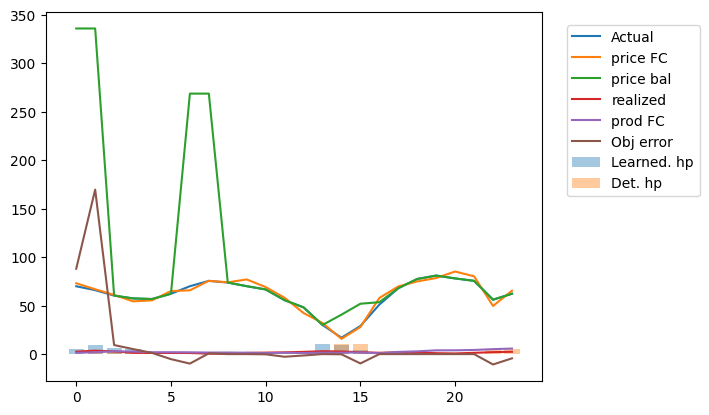

Day is 239


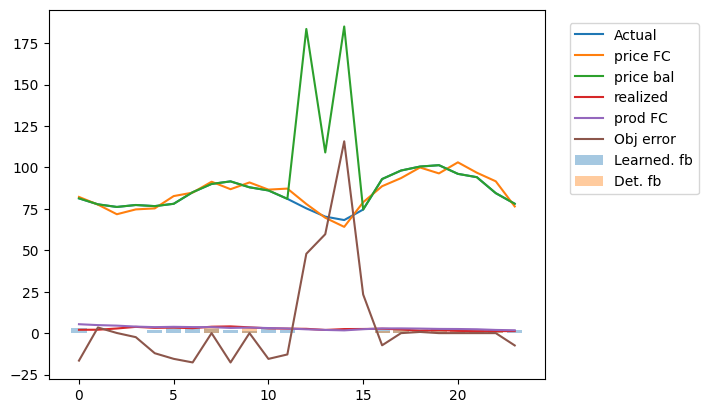

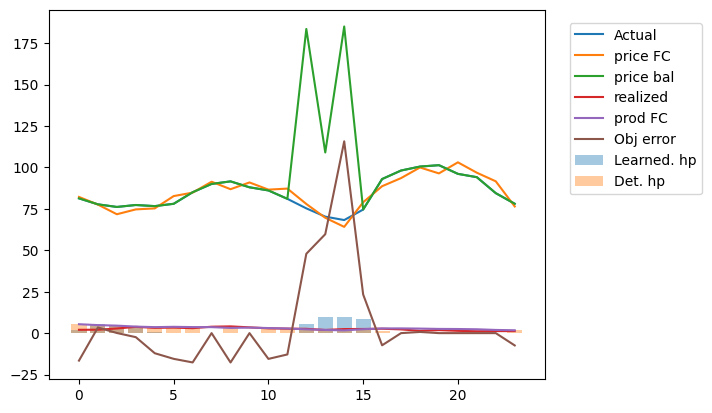

Day is 240


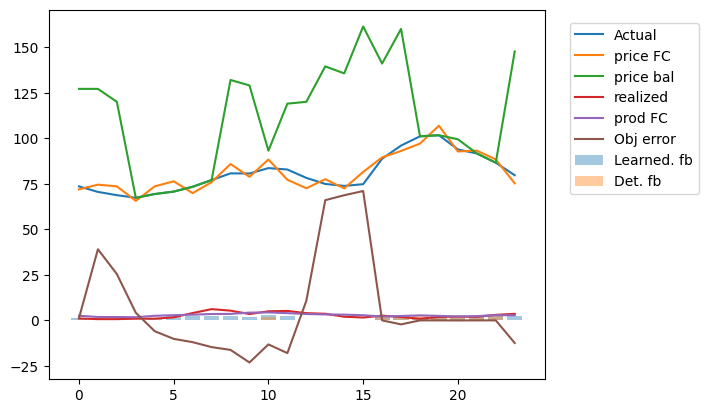

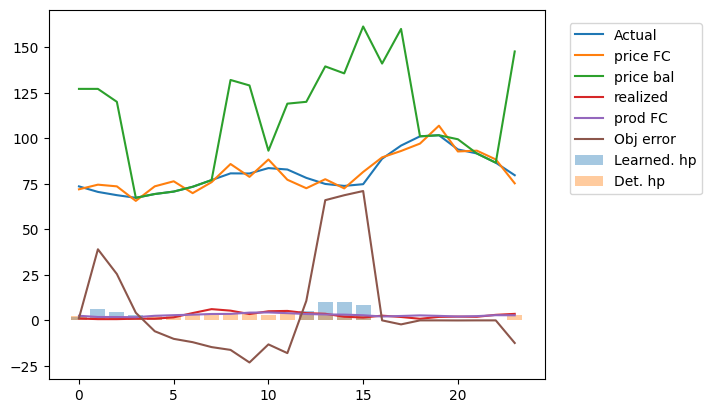

Day is 257


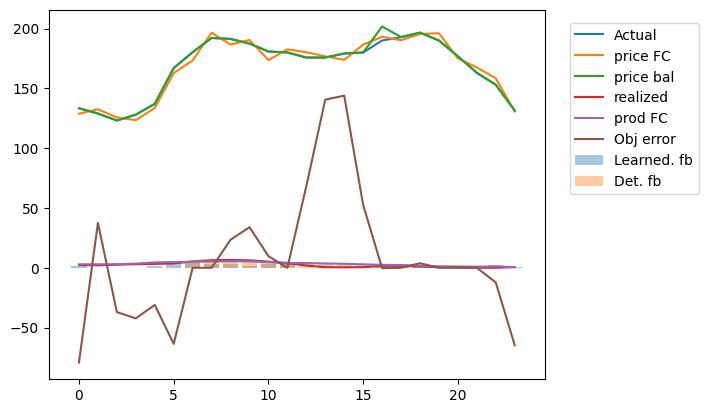

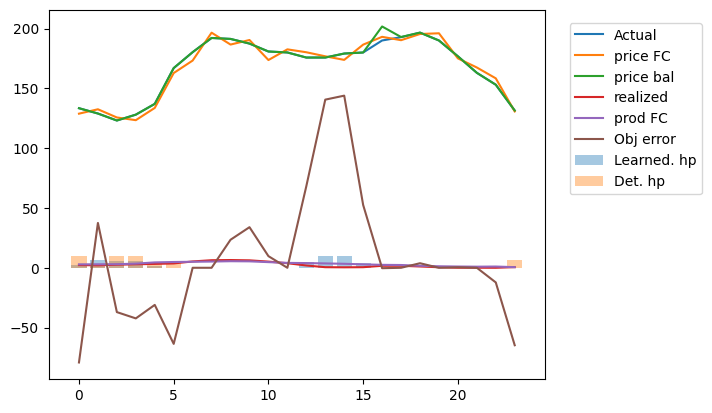

Day is 259


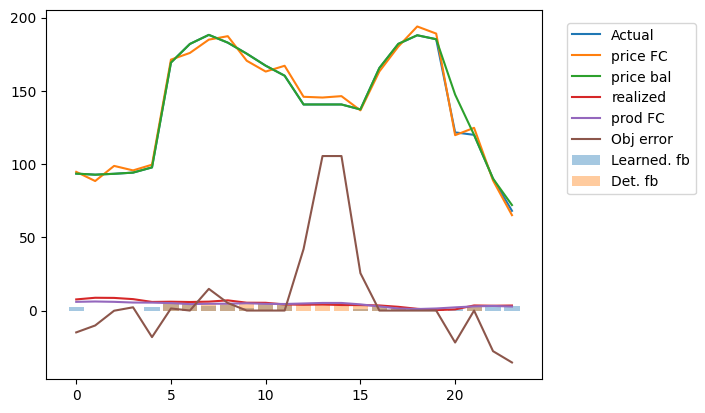

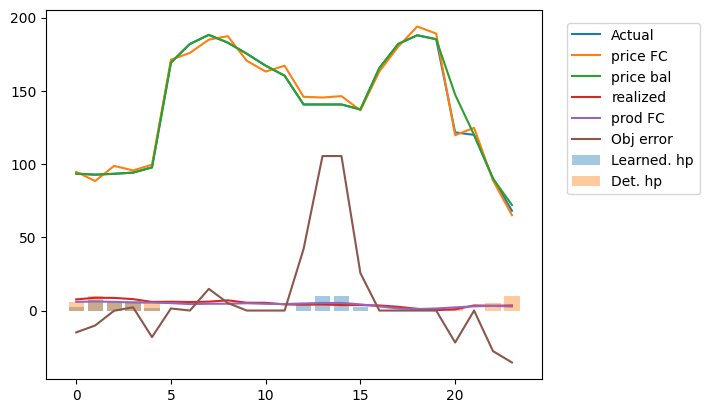

Day is 262


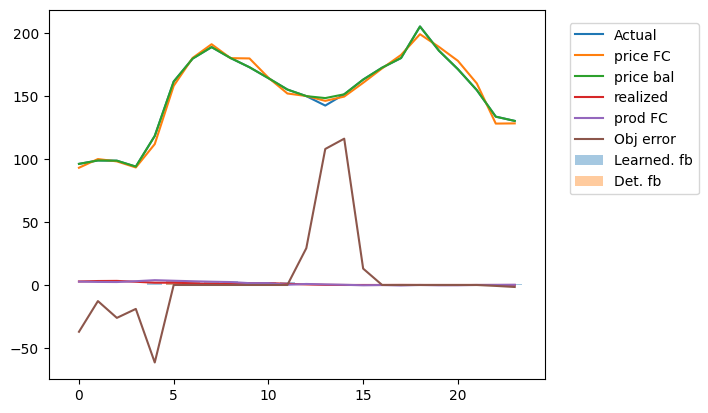

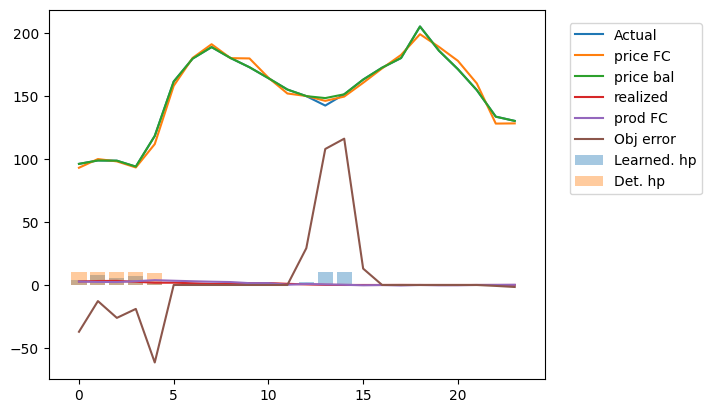

Day is 264


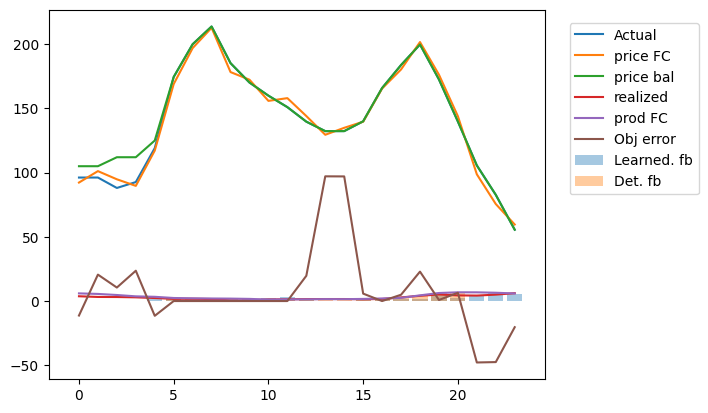

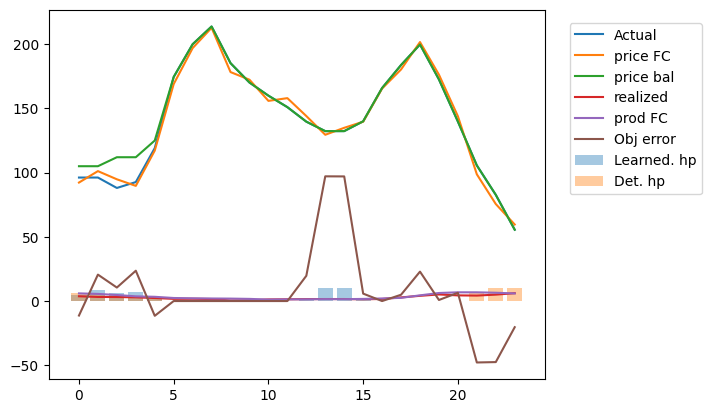

In [251]:
##--------------LEARNED vs OPTIMIZING
xs = np.array(list(range(24)))
w = 0.25
pcounter=0
for d in range(len(det_error)):
    if pcounter > 12:
        break
    if learn_error[d] > 1000:
        start = d * 24
        end = d * 24 + 24
        print(f"Day is {d}")
        # print(f"d={d}, h={h}, fp={prices_F[t]}, bp={prices_B[t]}, sp={prices_S[t]}, fc={forecast[t]}, real={realized[t]}")
        # print(f"Opt {results_o['obj'][i]:.2f}: fb={results_o['forward_bid'][i]:.2f}, hp={results_o['h_prod'][i]:.2f}, b={results_o['bought'][i]:.2f}, s={results_o['sold'][i]:.2f}, mis={results_o['missing_production'][i]:.2f}")
        # print(f"det {det_std['obj'][i]:.2f}: fb={det_std['forward_bid'][i]:.2f}, hp={det_std['h_prod'][i]:.2f}, b={det_std['bought'][i]:.2f}, s={det_std['sold'][i]:.2f}, mis={det_std['missing_production'][i]:.2f}")
        plt.figure()
        plt.plot(xs, prices_F[idx_start+start:idx_start+end], label="Actual")
        plt.plot(xs, prices_F_fc[idx_start+start:idx_start+end], label="price FC")
        plt.plot(xs, prices_bal[idx_start+start:idx_start+end], label="price bal")
        plt.plot(xs, realized[idx_start+start:idx_start+end], label="realized")
        plt.plot(xs, forecast[idx_start+start:idx_start+end], label="prod FC")
        plt.plot(xs, learn_error_hourly[start:end], label="Obj error")
        plt.bar(xs, result_cqs_risky['forward_bid'][start:end], label="Learned. fb", alpha=0.4)
        plt.bar(xs, det_std['forward_bid'][start:end], label="Det. fb", alpha=0.4)
        plt.legend(loc=(1.05, 0.5))
        plt.figure()
        plt.plot(xs, prices_F[idx_start+start:idx_start+end], label="Actual")
        plt.plot(xs, prices_F_fc[idx_start+start:idx_start+end], label="price FC")
        plt.plot(xs, prices_bal[idx_start+start:idx_start+end], label="price bal")
        plt.plot(xs, realized[idx_start+start:idx_start+end], label="realized")
        plt.plot(xs, forecast[idx_start+start:idx_start+end], label="prod FC")
        plt.plot(xs, learn_error_hourly[start:end], label="Obj error")
        plt.bar(xs, result_cqs_risky['h_prod'][start:end], label="Learned. hp", alpha=0.4)
        plt.bar(xs, det_std['h_prod'][start:end], label="Det. hp", alpha=0.4)
        plt.legend(loc=(1.05, 0.5))
        plt.show()
        pcounter += 1
        


### Only testing wind part

Deterministic revenue is 26.51 % of optimal
trained revenue is 39.26 % of optimal


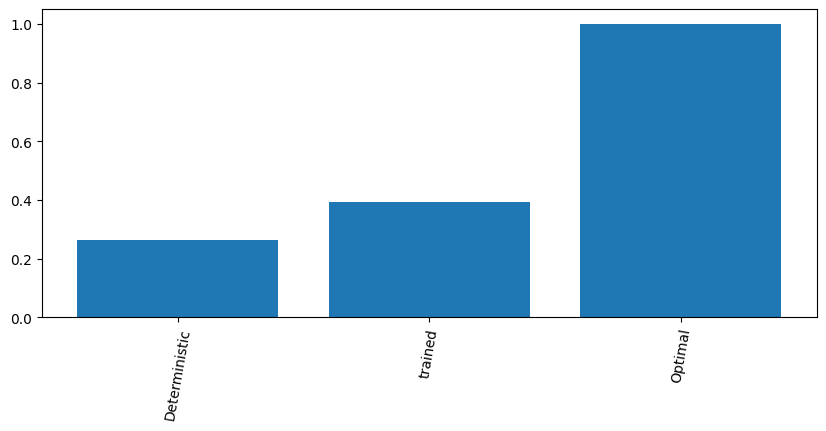

In [23]:

#----------Investing wind bidding isolated
opt_wind = [prices_F[t] * realized[t] for t in range(idx_start, idx_end)]
det_wind = [prices_F[t] * results_d_c['forward_bid'][i] - prices_B[t] * results_d_c['bought'][i] + prices_S[t] * results_d_c['sold'][i] for i, t in enumerate(range(idx_start, idx_end))]
retrained_wind = [prices_F[t] * result_cqs['forward_bid'][i] - prices_B[t] * result_cqs['bought'][i] + prices_S[t] * result_cqs['sold'][i] for i, t in enumerate(range(idx_start, idx_end))]

wind_obj_values = [np.sum(det_wind), np.sum(retrained_wind), np.sum(opt_wind)]
wind_obj_values /= np.sum(opt_wind)
wind_names = ["Deterministic", "trained", "Optimal",]

plot_resulting_objectives(wind_obj_values, wind_names)